# Introdução

A popularização de modelos generativos de imagens, especialmente arquiteturas baseadas em **Generative Adversarial Networks (GANs)** e, mais recentemente, em Diffusion Models, resultou em um avanço significativo na criação de imagens sintéticas altamente realistas. Ferramentas como **Stable Diffusion, Midjourney, DALL·E e Flux** tornaram possível gerar conteúdo visual praticamente indistinguível de fotografias reais, ampliando aplicações em arte, design e entretenimento. Entretanto, esse avanço também intensificou riscos relacionados à desinformação, fraudes visuais, deepfakes e manipulação de evidências digitais. Como consequência, a detecção automatizada de imagens geradas por IA tornou-se um tema central em pesquisa científica, segurança digital e processamento de imagens.

O presente trabalho propõe e implementa um sistema híbrido de detecção de imagens sintéticas, unindo duas abordagens complementares:

**(i) um modelo ViT fine-tuned para classificação binária (Real × IA)**, responsável por capturar padrões semânticos e estruturais globais; e

**(ii) um módulo de Edge-Based Processing (EBP)** e extração de fingerprints espectrais, destinado a identificar artefatos de alta frequência, variação estrutural e assinaturas de difusão presentes em imagens geradas por IA.


Neste contexto, o presente trabalho é direcionado exclusivamente ao dataset CIFAKE, com foco na obtenção de resultados estatísticos robustos dentro desse ambiente experimental.

O objetivo central é maximizar métricas de acurácia, precisão, recall e F1-score no CIFAKE, analisando a eficácia das abordagens combinadas nesse domínio específico.

Embora o foco do estudo seja restrito ao CIFAKE e não vise generalização direta para modelos atuais como **NANO BANANA PRO**, cenários do mundo real, a análise conduzida permite compreender como diferentes técnicas de detecção se comportam diante de um conjunto gerado por modelos diffusion e possibilita uma avaliação sistemática da arquitetura híbrida adotada. Assim, o trabalho contribui para o entendimento das potencialidades e limitações dessas abordagens dentro de um benchmark amplamente utilizado na literatura científica contemporânea.

### Ferramentas Utilizadas


**PyTorch**: Execução em GPU, fine-tuning do Vision Transformer e inferência acelerada.

**Hugging Face Transformers:** Carregamento do modelo ViT-base-patch16-224, pré-processamento e pipeline de classificação.

**CUDA (GPU T4 – Google Colab):** Aceleração do treinamento e das operações matriciais do modelo.

**OpenCV (cv2):** Implementação do módulo EBP (Edge-Based Processing): blur, Canny, mapas de borda e variância estrutural.

**NumPy:** Operações numéricas, manipulação de tensores, FFT e cálculos estatísticos do score estrutural S.

**Pandas:** Organização das predições, tabelas de métricas e gerenciamento dos conjuntos train/val/test.

**Matplotlib & Seaborn:** Visualização de métricas, curvas de treinamento, histogramas e análises gráficas.

**Scikit-learn:** Cálculo de accuracy, precision, recall, F1-score e matriz de confusão.

**Google Colab:** Ambiente de execução, gerenciamento de GPU T4 e armazenamento dos checkpoints treinados.

**Dataset CIFAKE**: Base experimental composta por imagens reais e sintéticas geradas por Stable Diffusion, usada para treino, validação, teste e calibração do EBP.

**Bibliotecas Necessarias**

In [14]:
pip install torch torchvision torchaudio transformers huggingface-hub opencv-python scikit-learn numpy evaluate

In [15]:
from datasets import load_dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np

import torch
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tqdm
from joblib import Parallel, delayed
import math
import os
from PIL import Image
import kagglehub

# Baixando o CIFAKE
 Este dataset (ID: 'birdy654/cifake-real-and-ai-generated-synthetic-images') já vem organizado para uso em machine learning,
 com as pastas separadas em treino, validação e teste. Ainda assim, as imagens precisam passar pelo pré-processamento:
 redimensionamento para 224x224, conversão para RGB, normalização e transformação em tensores para o modelo.


In [16]:
dataset_id = 'birdy654/cifake-real-and-ai-generated-synthetic-images'
dataset_path = kagglehub.dataset_download(dataset_id)
print(f"CIFAKE dataset downloaded em: {dataset_path}")

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
CIFAKE dataset downloaded em: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [17]:

print(f"Contents: {os.listdir(dataset_path)}")


Contents: ['test', 'train']


In [18]:
train_path = os.path.join(dataset_path, 'train')

print(f"Contents de 'train': {os.listdir(train_path)}")

Contents de 'train': ['FAKE', 'REAL']


Observando o TEST


In [19]:
test_path = os.path.join(dataset_path, 'test')


print(f"Contents de 'test': {os.listdir(test_path)}")

Contents de 'test': ['FAKE', 'REAL']


# Pre-Processamento

As imagens do CIFAKE apresentam resolução original de **32×32** pixels e são armazenadas no espaço de cor RGB. Entretanto, o Vision Transformer requer entradas em resolução **224×224**, devido à sua divisão interna em patches de **16×16** pixels e às restrições impostas pelos embeddings de posição. Dessa forma, todas as imagens foram redimensionadas para **224×224**, de modo a assegurar compatibilidade estrutural com o modelo e permitir a extração adequada de representações a partir dos tokens visuais.

In [20]:
def denormalize_and_display_image(image_tensor, mean, std, title="Sample Image"):

    # Converte o tensor para NumPy e reorganiza os canais para o formato (H, W, C)
    image_np = image_tensor.numpy().transpose((1, 2, 0))

    # Reverte a normalização aplicada anteriormente
    mean_np = np.array(mean)
    std_np = np.array(std)
    image_np = image_np * std_np + mean_np

    # Garante que os valores fiquem dentro do intervalo [0, 1]
    image_np = np.clip(image_np, 0, 1)

    # Converte para imagem PIL (aqui os valores são trazidos para a faixa 0–255)
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8))

    plt.figure(figsize=(6, 6))
    plt.imshow(image_pil)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [21]:
# 2. Inicializa o AutoImageProcessor do ViT
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224',use_fast=True)
print("AutoImageProcessor inicializado.")

# 3. Função de pré-processamento da imagem
def preprocess_image(image):
    # Garante que a imagem esteja no formato RGB
    image = image.convert('RGB')
    # Aplica o pré-processamento padrão do ViT
    # O processor retorna um dicionário; aqui pegamos apenas o tensor de pixels
    return processor(images=image, return_tensors="pt")['pixel_values'][0]

print("Função preprocess_image definida.")

# 4. Cria o dataset de treino usando ImageFolder
train_dataset = ImageFolder(root=train_path, transform=preprocess_image)
print("Dataset de treinamento criado.")

# 5. Cria o dataset de teste
test_dataset = ImageFolder(root=test_path, transform=preprocess_image)
print("Dataset de teste criado.")

# 6. Mostra quantas imagens existem em cada conjunto
print(f"Total de imagens no conjunto de treino: {len(train_dataset)}")
print(f"Total de imagens no conjunto de teste: {len(test_dataset)}")


AutoImageProcessor inicializado.
Função preprocess_image definida.
Dataset de treinamento criado.
Dataset de teste criado.
Total de imagens no conjunto de treino: 100000
Total de imagens no conjunto de teste: 20000


## Dividir o Dataset


In [ ]:
total_train_size = len(train_dataset)

# 80% para treino, 20% para calibração
new_train_size = int(0.8 * total_train_size)
calibration_size = total_train_size - new_train_size

# Divisão aleatória do dataset
new_train_dataset, calibration_dataset = random_split(
    train_dataset,
    [new_train_size, calibration_size]
)


print(f"Total no novo treino: {len(new_train_dataset)}")
print(f"Total no conjunto de calibração: {len(calibration_dataset)}")
print(f"Total no conjunto de teste: {len(test_dataset)}")


Total no novo treino: 80000
Total no conjunto de calibração: 20000
Total no conjunto de teste: 20000


Carregand o modelo Vision Transformer pré-treinado 'google/vit-base-patch16-224-in21k' da biblioteca Hugging Face Transformers, configurado para a tarefa de classificação de imagens.

In [22]:
# Nome das classes do dataset
class_names = train_dataset.classes
print(f"Class names from dataset: {class_names}")

#  id2label label2id
id2label = {idx: label for idx, label in enumerate(class_names)}
label2id = {label: idx for idx, label in enumerate(class_names)}

print(f"id2label mapping: {id2label}")
print(f"label2id mapping: {label2id}")

# Carrega o Modelo
model = AutoModelForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(class_names),
    id2label=id2label,
    label2id=label2id
)


Class names from dataset: ['FAKE', 'REAL']
id2label mapping: {0: 'FAKE', 1: 'REAL'}
label2id mapping: {'FAKE': 0, 'REAL': 1}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Esse passo é necessario apenas se não tiver o modelo, é o finetunning.
# É importante deixar os prints, fica bem aesthethic o acompanhamento do treinamento
# 1️⃣ Carregar Dataset CIFAKE (já baixado)

dataset_path = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images"
train_path, test_path = os.path.join(dataset_path, "train"), os.path.join(dataset_path, "test")

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224", use_fast=True)

def preprocess_image(image):
    image = image.convert("RGB")
    return processor(images=image, return_tensors="pt")["pixel_values"][0]

train_dataset = ImageFolder(root=train_path, transform=preprocess_image)
test_dataset  = ImageFolder(root=test_path,  transform=preprocess_image)

total_train = len(train_dataset)
train_size, calib_size = int(0.8 * total_train), total_train - int(0.8 * total_train)
new_train_dataset, calibration_dataset = random_split(train_dataset, [train_size, calib_size])

print(f"✅ Dataset pronto: train={len(new_train_dataset)}, val={len(calibration_dataset)}, test={len(test_dataset)}")

# 2️⃣ Carregar modelo ViT pré-treinado

class_names = train_dataset.classes
id2label = {i: c for i, c in enumerate(class_names)}
label2id = {c: i for i, c in enumerate(class_names)}

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(class_names),
    id2label=id2label,
    label2id=label2id,
)

print("✅ Modelo ViT pré-treinado carregado.")


# 3️⃣ Configurações de Treino (GPU / memória / eficiência) EXTREMAMENTE IMPORTANTE PARA RODAR NO COLAB

if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    torch.cuda.empty_cache()
    print(f"🧹 GPU disponível: {device_name}, cache limpa.")

training_args = TrainingArguments(
    output_dir="./vit-fine-tuned-cifake",
    num_train_epochs=5,
    per_device_train_batch_size=16,           # menor batch para reduzir memória
    gradient_accumulation_steps=2,            # acumula gradientes para batch efetivo maior
    gradient_checkpointing=True,              # ativa checkpointing para economizar memória :contentReference[oaicite:2]{index=2}
    learning_rate=1e-5,
    weight_decay=0.05,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    fp16=True,                                # mixed precision para economizar memória / acelerar :contentReference[oaicite:3]{index=3}
    dataloader_num_workers=6,
    logging_strategy="epoch",                 # só log por epoch
    report_to="none"
)
print("⚙️ TrainingArguments configurados com otimizações de memória e eficiência.")

# 4️⃣ Métrica de avaliação
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    acc = metric.compute(predictions=preds, references=labels)
    return {"eval_accuracy": acc["accuracy"]}

# 5️⃣ Data collator e callback para log por época
class CustomDataCollator:
    def __call__(self, features):
        pixel_values = torch.stack([f[0] for f in features])
        labels = torch.tensor([f[1] for f in features], dtype=torch.long)
        return {"pixel_values": pixel_values, "labels": labels}

class EpochLogger(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        logs = state.log_history[-1] if state.log_history else {}
        print(f"\n🧠 Epoch {int(state.epoch)}/{int(args.num_train_epochs)} FEITO")
        if "eval_loss" in logs:      print(f"📉 Validation Loss: {logs['eval_loss']:.4f}")
        if "loss" in logs:           print(f"💪 Training Loss: {logs['loss']:.4f}")
        if "eval_accuracy" in logs:  print(f"🎯 Accuracy: {logs['eval_accuracy']*100:.2f}%")


# 6️⃣ Inicializar Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=new_train_dataset,
    eval_dataset=calibration_dataset,
    compute_metrics=compute_metrics,
    data_collator=CustomDataCollator(),
    callbacks=[EpochLogger()]
)

print("🚀 Trainer inicializado com otimização de memória.")


# 7️⃣ Executar Treinamento
train_results = trainer.train()
print("\n✅ Treinamento concluído.")

# 8️⃣ Avaliar no conjunto de teste
metrics = trainer.evaluate(test_dataset)
print("\n📊 Avaliação final no conjunto de teste:")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Dataset pronto: train=80000, val=20000, test=20000
✅ Modelo ViT pré-treinado carregado.
🧹 GPU disponível: Tesla T4, cache limpa.
⚙️ TrainingArguments configurados com otimizações de memória e eficiência.


🚀 Trainer inicializado com otimização de memória.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.119000,0.058486,0.982950
2,0.040600,0.048672,0.984350
3,0.020100,0.048493,0.987500
4,0.008200,0.052467,0.988200
5,0.003100,0.054939,0.988950



🧠 Epoch 1/5 FEITO


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



🧠 Epoch 2/5 FEITO
📉 Validation Loss: 0.0585
🎯 Accuracy: 98.30%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



🧠 Epoch 3/5 FEITO
📉 Validation Loss: 0.0487
🎯 Accuracy: 98.43%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



🧠 Epoch 4/5 FEITO
📉 Validation Loss: 0.0485
🎯 Accuracy: 98.75%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



🧠 Epoch 5/5 FEITO
📉 Validation Loss: 0.0525
🎯 Accuracy: 98.82%

✅ Treinamento concluído.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



📊 Avaliação final no conjunto de teste:
  eval_accuracy: 0.9889
  eval_loss: 0.0547
  eval_runtime: 80.3483
  eval_samples_per_second: 248.9160
  eval_steps_per_second: 31.1150
  epoch: 5.0000


In [ ]:
best_checkpoint = "/content/vit-fine-tuned-cifake/checkpoint-12500"

# Caminho final para salvar o modelo completo
save_path = "/content/vit-final"
os.makedirs(save_path, exist_ok=True)

# 1) modelo do melhor checkpoint
model = AutoModelForImageClassification.from_pretrained(best_checkpoint)

# 2) processor original do ViT
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# 3) salva modelo e processor juntos
model.save_pretrained(save_path)
processor.save_pretrained(save_path)

print("Modelo e processor salvos em:", save_path)
print("Arquivos salvos:")
print(os.listdir(save_path))


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Modelo e processor salvos em: /content/vit-final
Arquivos salvos:
['config.json', 'preprocessor_config.json', 'model.safetensors']


# loading no modelo


In [ ]:
load_dir = "/content/drive/MyDrive/vit_final"

model = AutoModelForImageClassification.from_pretrained(load_dir)
processor = AutoImageProcessor.from_pretrained(load_dir)

print("Modelo carregado.")

Modelo carregado.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
load_dir = "/content/drive/MyDrive/vit_final"

# Check if the directory exists
if not os.path.exists(load_dir):
    print(f"Erro: O diretório '{load_dir}' não foi encontrado. Por favor, verifique se a pasta 'vit_final' está no seu Google Drive.")
else:
    print(f"Diretório '{load_dir}' encontrado.")
    print(f"Conteúdo do diretório '{load_dir}': {os.listdir(load_dir)}")

    # Check for specific required files
    required_files = ['preprocessor_config.json', 'config.json', 'model.safetensors']
    missing_files = [f for f in required_files if f not in os.listdir(load_dir)]

    if missing_files:
        print(f"Erro: Os seguintes arquivos essenciais estão faltando ou não estão diretamente na pasta '{load_dir}': {missing_files}")
        print("Por favor, verifique se todos os arquivos do modelo estão diretamente dentro da pasta 'vit_final' no seu Google Drive.")
    else:
        try:
            model = AutoModelForImageClassification.from_pretrained(load_dir, local_files_only=True)
            processor = AutoImageProcessor.from_pretrained(load_dir, local_files_only=True)
            print("Modelo e processador carregados com sucesso de:", load_dir)
        except Exception as e:
            print(f"Erro ao carregar o modelo/processador, mesmo com local_files_only=True: {e}")
            print("Certifique-se de que a pasta 'vit_final' no seu Google Drive contém os arquivos corretos do modelo e que eles não estão dentro de subpastas.")

Diretório '/content/drive/MyDrive/vit_final' encontrado.
Conteúdo do diretório '/content/drive/MyDrive/vit_final': ['preprocessor_config.json', 'model.safetensors', 'config.json']


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Modelo e processador carregados com sucesso de: /content/drive/MyDrive/vit_final


## Gerando predições e identificar classificações incorretas

1. Devemos fazer as predições do modelo ViT no conjunto de teste

2. Dps percorrer o conjunto de teste imagem por imagem.

3. Para cada imagem, gerar a predição do ViT.

4. E no final comparar a predição com o rótulo verdadeiro.

 todas as imagens classificadas incorretamente em uma lista chamada misclassified_images.

Apenas essas imagens serão refinadas pelo módulo Edge-Based.

In [ ]:
misclassified_images = []

# Média e desvio padrão usados pelo ViT para normalização das imagens
# (vamos precisar deles depois para denormalizar e visualizar imagens)
mean = processor.image_mean
std = processor.image_std

# Define o dispositivo de execução (GPU se disponível, caso contrário CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Coloca o modelo em modo de avaliação

print(f"Iniciando inferência no conjunto de teste ({len(test_dataset)} imagens) no dispositivo: {device}")

# Percorre todas as imagens do conjunto de teste
for i, (image_tensor, true_label_idx) in enumerate(test_dataset):

    # O modelo espera um batch, então adicionamos uma dimensão extra
    # e movemos a imagem para GPU (ou CPU se GPU não existir)
    inputs = image_tensor.unsqueeze(0).to(device)

    # Desativa o cálculo de gradiente para acelerar a inferência
    with torch.no_grad():
        outputs = model(inputs)

    # Obtém as probabilidades (logits) e converte para classe predita
    logits = outputs.logits
    predicted_label_idx = torch.argmax(logits, dim=1).item()

    # Recupera os nomes das classes (REAL / FAKE)
    true_label_name = id2label[true_label_idx]
    predicted_label_name = id2label[predicted_label_idx]

    # Se o modelo errou, armazenamos esta imagem para análise posterior
    if predicted_label_idx != true_label_idx:
        misclassified_images.append({
            'image_tensor': image_tensor.cpu(),  # Guarda na CPU para economizar memória
            'true_label': true_label_name,
            'predicted_label': predicted_label_name
        })

    # Exibe progresso a cada 1000 imagens processadas
    if (i + 1) % 1000 == 0:
        print(f"  Processadas {i + 1}/{len(test_dataset)} imagens.")

# Resumo final
print(f"Inferência concluída. Total de imagens classificadas incorretamente: {len(misclassified_images)}")

Iniciando inferência no conjunto de teste (20000 imagens) no dispositivo: cuda
  Processadas 1000/20000 imagens.
  Processadas 2000/20000 imagens.
  Processadas 3000/20000 imagens.
  Processadas 4000/20000 imagens.
  Processadas 5000/20000 imagens.
  Processadas 6000/20000 imagens.
  Processadas 7000/20000 imagens.
  Processadas 8000/20000 imagens.
  Processadas 9000/20000 imagens.
  Processadas 10000/20000 imagens.
  Processadas 11000/20000 imagens.
  Processadas 12000/20000 imagens.
  Processadas 13000/20000 imagens.
  Processadas 14000/20000 imagens.
  Processadas 15000/20000 imagens.
  Processadas 16000/20000 imagens.
  Processadas 17000/20000 imagens.
  Processadas 18000/20000 imagens.
  Processadas 19000/20000 imagens.
  Processadas 20000/20000 imagens.
Inferência concluída. Total de imagens classificadas incorretamente: 221


## Exibir resultados

Mostran o número total de imagens classificadas incorretamente e alguns exemplos dessas imagens, se houver, incluindo seus rótulos verdadeiros e preditos.


Total de imagens classificadas incorretamente: 221

Exemplos de imagens classificadas incorretamente:


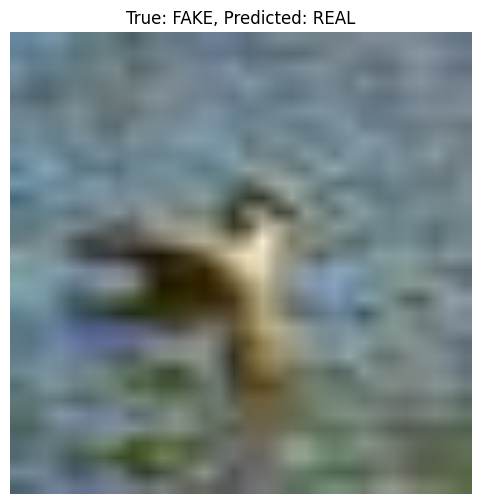

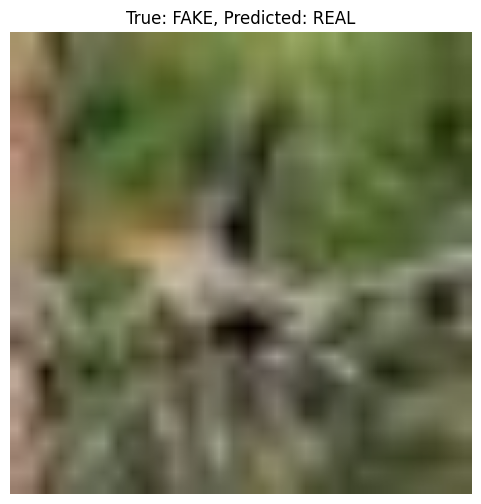

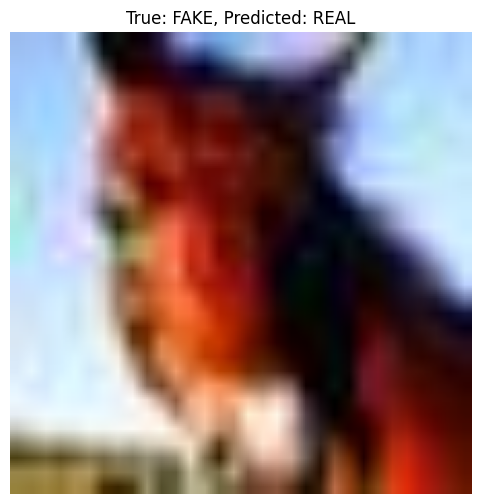

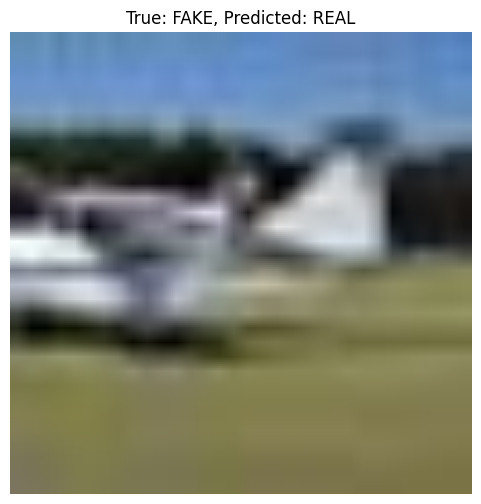

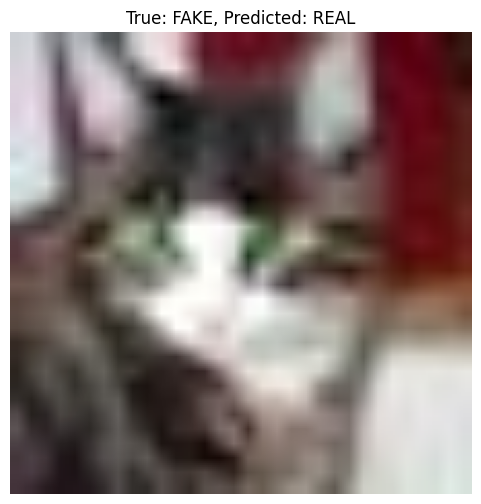

In [ ]:
print(f"Total de imagens classificadas incorretamente: {len(misclassified_images)}")

if misclassified_images:
    print("\nExemplos de imagens classificadas incorretamente:")
    for i, item in enumerate(misclassified_images[:5]):
        image_tensor = item['image_tensor']
        true_label = item['true_label']
        predicted_label = item['predicted_label']
        title = f"True: {true_label}, Predicted: {predicted_label}"
        denormalize_and_display_image(image_tensor, mean, std, title=title)
else:
    print("Nenhuma imagem classificada incorretamente encontrada.")

## Preparar imagens para análise de bordas

Para cada imagem (tanto do conjunto de calibração quanto das misclassified do teste):
Vamos conerter a imagem para escala de cinza.
Dps aplicar um Gaussian Blur 3×3 para suavizar ruído.
E guardar tanto a imagem original em grayscale quanto a borrada.

In [ ]:

def denormalize_image_tensor(image_tensor, mean, std):
    """
    Converte um tensor normalizado (como o usado pelo ViT) de volta para uma imagem
    no formato padrão (0–255) e em array NumPy, pronta para uso no OpenCV.

    1. Move o tensor para CPU e converte para NumPy.
    2. Reorganiza os canais de (C, H, W) para (H, W, C).
    3. Aplica a denormalização: img = img * std + mean.
    4. Converte os valores para o intervalo de 0–255 e tipo uint8.
    """

    # Garante que o tensor esteja na CPU e converte para NumPy
    image_np = image_tensor.cpu().numpy()

    # Converte o formato do tensor para o padrão do OpenCV (H, W, C)
    image_np = image_np.transpose((1, 2, 0))

    # Converte mean e std para arrays NumPy e desfaz a normalização
    mean_np = np.array(mean)
    std_np = np.array(std)
    image_np = image_np * std_np + mean_np

    # Redimensiona para faixa 0–255 e converte para uint8
    image_np = (image_np * 255).astype(np.uint8)

    return image_np


def preprocess_for_ebp(image_np):
    """
    1. Converte a imagem RGB para escala de cinza.
    2. Aplica suavização com Gaussian Blur 3×3.
    Retorna:
        - imagem em grayscale
        - imagem borrada
    """

    # Converte RGB → grayscale
    gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    # Suaviza a imagem para reduzir ruído antes do Canny
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

    return gray_image, blurred_image


print("Helper functions `denormalize_image_tensor`  `preprocess_for_ebp` definidas.")


Helper functions `denormalize_image_tensor`  `preprocess_for_ebp` definidas.


Agora que as funções auxiliares de pré-processamento estão definidas, o próximo passo é aplicá-las ao **calibration_dataset**. Cada tensor de imagem será desnormalizado, depois convertido para escala de cinza e borrado. Os resultados (imagem original em escala de cinza e imagem borrada) serão armazenados em uma nova lista chamada **calibration_processed_images**

Este bloco percorre todas as imagens do conjunto de calibração e aplica o pré-processamento necessário para o módulo Edge-Based. Para cada imagem, o tensor é desnormalizado para recuperar a imagem original, depois convertido para escala de cinza e borrado com Gaussian Blur. Em seguida, essas duas versões da imagem  grayscale e borrada  são armazenadas na lista calibration_processed_images, juntamente com o rótulo verdadeiro.

Isso prepara o conjunto de calibração para as próximas etapas, onde serão calculados os mapas de borda, o mapa de diferença e o Structural Score (SI) usado no cálculo

In [ ]:
calibration_processed_images = []

total_images = len(calibration_dataset)
print(f"Processando {total_images} imagens do conjunto de calibração para EBP...")

# Prints a cada 5% do dataset (20 passos)
progress_step = max(1, total_images // 20)

for i, (image_tensor, true_label_idx) in enumerate(calibration_dataset):

    # Desnormalizar imagem
    denorm = denormalize_image_tensor(image_tensor, mean, std)

    # Gerar grayscale + blur
    gray, blurred = preprocess_for_ebp(denorm)

    # Armazenar resultados
    calibration_processed_images.append({
        "original_grayscale": gray,
        "blurred": blurred,
        "true_label": id2label[true_label_idx]
    })

    if (i + 1) % progress_step == 0:
        print(f"  Processadas: {i + 1}/{total_images}")

print("\nProcessamento concluído.")
print(f"Total de imagens processadas: {len(calibration_processed_images)}")


Processando 20000 imagens do conjunto de calibração para EBP...
  Processadas: 1000/20000
  Processadas: 2000/20000
  Processadas: 3000/20000
  Processadas: 4000/20000
  Processadas: 5000/20000
  Processadas: 6000/20000
  Processadas: 7000/20000
  Processadas: 8000/20000
  Processadas: 9000/20000
  Processadas: 10000/20000
  Processadas: 11000/20000
  Processadas: 12000/20000
  Processadas: 13000/20000
  Processadas: 14000/20000
  Processadas: 15000/20000
  Processadas: 16000/20000
  Processadas: 17000/20000
  Processadas: 18000/20000
  Processadas: 19000/20000
  Processadas: 20000/20000

Processamento concluído.
Total de imagens processadas: 20000


Após processar o conjunto de calibração, o próximo passo lógico é aplicar o mesmo pré-processamento EBP (**desnormalização, conversão para escala de cinza e borramento**) à lista misclassified_images. Isso garante consistência na preparação de todas as imagens que passarão pela análise de bordas. A lista original misclassified_images será atualizada para incluir essas novas versões processadas.

In [ ]:
total_mis = len(misclassified_images)
print(f"Processando {total_mis} imagens classificadas incorretamente para EBP...")

# Definir tamanho dos passos de progresso (20 updates)
progress_step = max(1, total_mis // 20)

for i, item in enumerate(misclassified_images):

    image_tensor = item["image_tensor"]

    # Desnormalização
    denorm = denormalize_image_tensor(image_tensor, mean, std)

    # Gerar grayscale + blur
    gray_img, blurred_img = preprocess_for_ebp(denorm)

    # Atualiza estrutura do item
    item["original_grayscale"] = gray_img
    item["blurred"] = blurred_img

    # Progresso em 20 passos
    if (i + 1) % progress_step == 0:
        print(f"  Processadas: {i + 1}/{total_mis}")

print("\nProcessamento das imagens classificadas incorretamente concluído.")
print(f"Total de imagens processadas: {len(misclassified_images)}")


Processando 221 imagens classificadas incorretamente para EBP...
  Processadas: 11/221
  Processadas: 22/221
  Processadas: 33/221
  Processadas: 44/221
  Processadas: 55/221
  Processadas: 66/221
  Processadas: 77/221
  Processadas: 88/221
  Processadas: 99/221
  Processadas: 110/221
  Processadas: 121/221
  Processadas: 132/221
  Processadas: 143/221
  Processadas: 154/221
  Processadas: 165/221
  Processadas: 176/221
  Processadas: 187/221
  Processadas: 198/221
  Processadas: 209/221
  Processadas: 220/221

Processamento das imagens classificadas incorretamente concluído.
Total de imagens processadas: 221


O próximo passo do módulo Edge-Based é extrair as bordas estruturais das imagens. Para isso, utiliza-se o detector de bordas Canny, que é um dos métodos mais eficientes para identificar transições bruscas de intensidade  exatamente o tipo de padrão que diferencia imagens reais de imagens sintéticas, segundo o paper. A função apply_canny_edge_detector encapsula essa etapa, aplicando o Canny com limites definidos (**50 e 150**), suficientes para capturar bordas relevantes sem excesso de ruído.

Em seguida, o código aplica esse detector a todas as imagens previamente preparadas no conjunto de calibração. Para cada imagem, são gerados dois mapas de borda: um a partir da versão original em grayscale (**E_orig**) e outro a partir da versão borrada (**E_blur**). Esses dois mapas são fundamentais para o cálculo do mapa de diferença estrutural, que será usado posteriormente na derivação do Structural Score **(SI)**.

O mesmo processo é repetido para as imagens que o ViT classificou incorretamente, garantindo que tanto o conjunto de calibração quanto as imagens misclassified sejam processados de forma consistente. O código também imprime o progresso em intervalos regulares, já que essas operações são computacionalmente intensivas. Ao final, cada item dessas listas passa a conter seus respectivos mapas de borda, permitindo seguir para a próxima etapa do pipeline: a construção do Edge Difference Map e o cálculo do score estrutural.

In [ ]:
def apply_canny(img):
    return cv2.Canny(img, threshold1=50, threshold2=150)

In [ ]:

# 1) PROCESSAR CALIBRATION (SEQUENCIAL)


total_cal = len(calibration_processed_images)
print(f"Aplicando Canny ao conjunto de calibração ({total_cal} imagens)...")

progress_step = max(1, total_cal // 20)  # 20 passos de progresso

for idx, item in enumerate(calibration_processed_images):

    # Aplica Canny nas duas versões da imagem
    item["E_orig"] = apply_canny(item["original_grayscale"])
    item["E_blur"]  = apply_canny(item["blurred"])

    # Progresso em passos regulares
    if (idx + 1) % progress_step == 0:
        print(f"  Processadas: {idx + 1}/{total_cal}")

print("Canny concluído para o conjunto de calibração.")



# 2) PROCESSAR MISCLASSIFIED (SEQUENCIAL)

total_mis = len(misclassified_images)
print(f"\nAplicando Canny às imagens misclassified ({total_mis} imagens)...")

progress_step_m = max(1, total_mis // 10)  # 10 passos de progresso

for idx, item in enumerate(misclassified_images):

    item["E_orig"] = apply_canny(item["original_grayscale"])
    item["E_blur"]  = apply_canny(item["blurred"])

    if (idx + 1) % progress_step_m == 0:
        print(f"  Processadas: {idx + 1}/{total_mis}")

print("\nCanny concluído para todos os conjuntos.")


Aplicando Canny ao conjunto de calibração (20000 imagens)...
  Processadas: 1000/20000
  Processadas: 2000/20000
  Processadas: 3000/20000
  Processadas: 4000/20000
  Processadas: 5000/20000
  Processadas: 6000/20000
  Processadas: 7000/20000
  Processadas: 8000/20000
  Processadas: 9000/20000
  Processadas: 10000/20000
  Processadas: 11000/20000
  Processadas: 12000/20000
  Processadas: 13000/20000
  Processadas: 14000/20000
  Processadas: 15000/20000
  Processadas: 16000/20000
  Processadas: 17000/20000
  Processadas: 18000/20000
  Processadas: 19000/20000
  Processadas: 20000/20000
Canny concluído para o conjunto de calibração.

Aplicando Canny às imagens misclassified (221 imagens)...
  Processadas: 22/221
  Processadas: 44/221
  Processadas: 66/221
  Processadas: 88/221
  Processadas: 110/221
  Processadas: 132/221
  Processadas: 154/221
  Processadas: 176/221
  Processadas: 198/221
  Processadas: 220/221

Canny concluído para todos os conjuntos.


## Calcular variância estrutural


O próximo passo é quantificar quão “carregada” de bordas cada imagem está  isso porque  imagens sintéticas tendem a apresentar padrões de bordas mais intensos e menos naturais, enquanto imagens reais apresentam distribuição mais suave.

A função calculate_structural_variance implementa exatamente essa ideia: ela conta quantos pixels de borda existem no mapa **(onde o Canny marca bordas como 255)** e divide pelo total de pixels, obtendo assim uma medida simples e direta da densidade de bordas na imagem.

O código aplica essa função aos dois mapas de borda gerados para cada imagem: o mapa da imagem original em grayscale **(S_orig**) e o da imagem borrada (**S_blur**). Essa dupla é importante, pois o desfoque reduz bordas artificiais e realça diferenças estruturais entre imagens reais e sintéticas. O processo é repetido tanto para o conjunto de calibração quanto para as imagens inicialmente classificadas incorretamente pelo ViT, garantindo consistência em todo o pipeline. Além disso, o progresso é exibido periodicamente devido ao alto custo computacional dessa etapa.

Esses valores de variância estrutural (**S_orig e S_blur**) servirão de base para calcular o Structural Score (**SI**) que o algoritmo do paper utiliza para distinguir imagens reais de imagens geradas por IA.

In [ ]:
# 1) Edge Difference Map (D)

def calculate_edge_difference_map(E_orig, E_blur):
    """
    Constrói o mapa D conforme descrito no paper:
      - D = 1 onde há borda em E_orig e NÃO há em E_blur
      - D = 0 caso contrário
    """
    E_orig_bin = (E_orig == 255).astype(np.uint8)
    E_blur_bin = (E_blur == 255).astype(np.uint8)

    D = (E_orig_bin & (~E_blur_bin)).astype(np.uint8)
    return D


# 2) Nedges e var(D)

def calculate_n_and_var_d(E_orig, D):
    """
    Calcula os valores fundamentais para o SI:
        Nedges = número total de pixels de borda em E_orig
        var(D) = variância estatística do mapa D
    """
    # Nedges = número de pixels 255 em E_orig
    E_orig_bin = (E_orig == 255).astype(np.uint8)
    Nedges = int(np.sum(E_orig_bin))

    # variância de D (0/1)
    var_D = float(np.var(D.astype(np.float32)))

    return Nedges, var_D



# 3) Structural Score (SI)


def calculate_structural_score_SI(Nedges, var_D, epsilon=1e-8):
    """
    Calcula o Structural Score conforme o paper:
        SI = Nedges / (var(D) + epsilon)
    """
    return Nedges / (var_D + epsilon)

In [ ]:
# 4) PROCESSAR CALIBRAÇÃO — gerar Nedges e var(D)


print("Calculando Nedges e variância de D para imagens de calibração...")

for i, item in enumerate(calibration_processed_images):

    # Construir mapa D
    D = calculate_edge_difference_map(item["E_orig"], item["E_blur"])

    # Calcular Nedges e var(D)
    Nedges, var_D = calculate_n_and_var_d(item["E_orig"], D)

    # Guardar
    item["Nedges"] = Nedges
    item["var_D"] = var_D

    # Barra de progresso simples
    if (i + 1) % 5000 == 0:
        print(f"  Processadas {i + 1}/{len(calibration_processed_images)} imagens.")

print("Cálculo de Nedges e variância concluído para calibração.")



# 5) PROCESSAR MISCLASSIFIED — gerar Nedges e var(D)

print("\nCalculando Nedges e variância de D para imagens misclassified...")

for i, item in enumerate(misclassified_images):

    # Construir mapa D
    D = calculate_edge_difference_map(item["E_orig"], item["E_blur"])

    # Calcular Nedges e var(D)
    Nedges, var_D = calculate_n_and_var_d(item["E_orig"], D)

    # Guardar
    item["Nedges"] = Nedges
    item["var_D"] = var_D

    if (i + 1) % 50 == 0:
        print(f"  Processadas {i + 1}/{len(misclassified_images)} imagens.")

print("Cálculo de Nedges e variância concluído para misclassified.")


Calculando Nedges e variância de D para imagens de calibração...
  Processadas 5000/20000 imagens.
  Processadas 10000/20000 imagens.
  Processadas 15000/20000 imagens.
  Processadas 20000/20000 imagens.
Cálculo de Nedges e variância concluído para calibração.

Calculando Nedges e variância de D para imagens misclassified...
  Processadas 50/221 imagens.
  Processadas 100/221 imagens.
  Processadas 150/221 imagens.
  Processadas 200/221 imagens.
Cálculo de Nedges e variância concluído para misclassified.


## Coletar e analisar scores de borda (Score S)


Depois de obter os mapas de borda originais e borrados, o passo seguinte é calcular o Structural Score (SI), que é o coração do método proposto no paper. Esse bloco implementa exatamente as três fórmulas descritas no Algorithm 2, seguindo fielmente o procedimento científico do artigo.

Primeiro, a função calculate_edge_difference_map constrói o mapa de diferença D, que identifica onde o mapa de bordas original tem mais bordas do que o mapa borrado. Isso isola padrões de bordas artificiais  muito comuns em imagens geradas por IA porque bordas “inventadas” pela rede tendem a desaparecer após o desfoque, revelando discrepância. O mapa final D é binário: 1 onde existe essa diferença, 0 no restante.

Em seguida, a função calculate_n_and_var_d calcula os dois componentes fundamentais do algoritmo:
N - o número total de pixels igual a 1 em D (**bordas que desapareceram com o blur**)
Var(**D**) - a variância do próprio mapa D, quantificando a distribuição dessas diferenças estruturais

Structural Score SI = N / (Var(D) +\ ε)\, onde ε evita divisão por zero e estabiliza a métrica.

O loop percorre todas as imagens de calibração, calcula D, extrai N e Var(D), computa o SI e armazena o valor em cada item do dataset. Esse score será usado para alimentar o Algorithm 1 (Valley Threshold), que calculará o limiar ótimo entre imagens reais e sintéticas.

In [ ]:
epsilon = 1e-8

In [ ]:
print("Calculando Structural Score (SI) para imagens de calibração...")

for i, item in enumerate(calibration_processed_images):

    # 1. Construir D (Edge Difference Map)
    D = calculate_edge_difference_map(item["E_orig"], item["E_blur"])

    # 2. Calcular Nedges e var(D) = estatísticas estruturais do paper
    Nedges, var_D = calculate_n_and_var_d(item["E_orig"], D)

    # 3. Calcular o Structural Score SI
    item["SI"] = calculate_structural_score_SI(Nedges, var_D, epsilon)

    # progresso
    if (i + 1) % 5000 == 0:
        print(f"  SI calculado para {i + 1}/{len(calibration_processed_images)} imagens.")

print("Structural Score (SI) calculado para todas as imagens de calibração.")


Calculando Structural Score (SI) para imagens de calibração...
  SI calculado para 5000/20000 imagens.
  SI calculado para 10000/20000 imagens.
  SI calculado para 15000/20000 imagens.
  SI calculado para 20000/20000 imagens.
Structural Score (SI) calculado para todas as imagens de calibração.


In [ ]:
real_scores_s = []
fake_scores_s = []

for item in calibration_processed_images:
    if item['true_label'] == 'REAL':
        real_scores_s.append(item['SI'])
    elif item['true_label'] == 'FAKE':
        fake_scores_s.append(item['SI'])

print(f"Coletados {len(real_scores_s)} scores SI para imagens REAL e {len(fake_scores_s)} para imagens FAKE.")

Coletados 10070 scores SI para imagens REAL e 9930 para imagens FAKE.


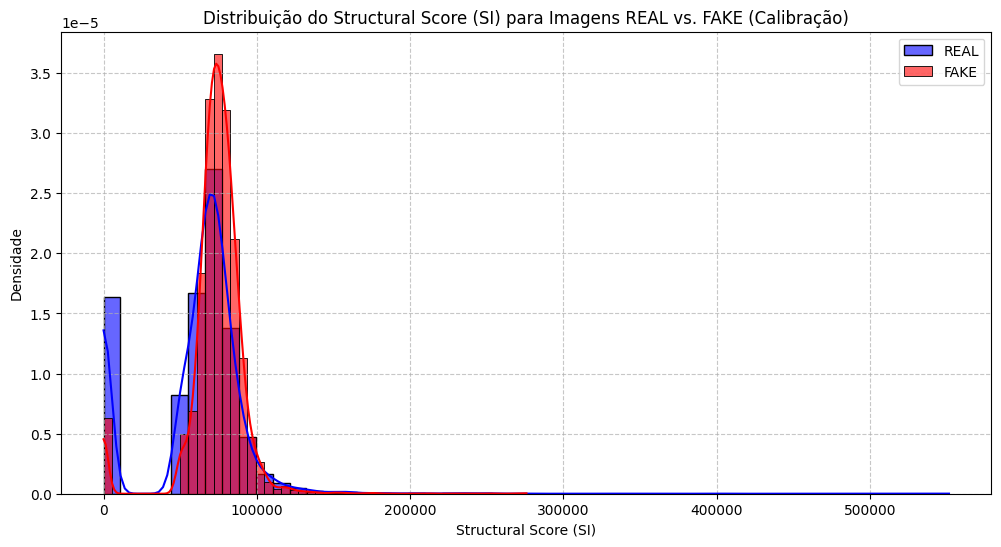

In [ ]:

plt.figure(figsize=(12, 6))
sns.histplot(real_scores_s, color='blue', label='REAL', kde=True, stat='density', alpha=0.6, bins=50)
sns.histplot(fake_scores_s, color='red', label='FAKE', kde=True, stat='density', alpha=0.6, bins=50)
plt.title('Distribuição do Structural Score (SI) para Imagens REAL vs. FAKE (Calibração)')
plt.xlabel('Structural Score (SI)')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



In [ ]:
# 1.  REAL e FAKE
S_R = np.array(real_scores_s)
S_F = np.array(fake_scores_s)

# 2. Calcular medianas
median_R = np.median(S_R)
median_F = np.median(S_F)

print(f"Mediana REAL: {median_R:.6f}")
print(f"Mediana FAKE: {median_F:.6f}")

# 3. Unir scores
S = np.concatenate((S_R, S_F))

# 4. histograma
counts, bin_edges = np.histogram(S, bins=50)

# 5. centros dos bins
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 6. Selecionar bins entre as medianas
min_median = min(median_R, median_F)
max_median = max(median_R, median_F)

mask = (bin_centers >= min_median) & (bin_centers <= max_median)
relevant_counts = counts[mask]
relevant_bin_centers = bin_centers[mask]

# 7. Encontrar o vale (bin com menor densidade)
if len(relevant_counts) > 0:
    valley_idx = np.argmin(relevant_counts)
    si_threshold = relevant_bin_centers[valley_idx]
    print(f"\nVale encontrado. Threshold final (Algorithm 1): {si_threshold:.6f}")
else:
    si_threshold = (median_R + median_F) / 2
    print(f"\nNenhum vale encontrado — usando média das medianas: {si_threshold:.6f}")


Mediana REAL: 67840.664116
Mediana FAKE: 74820.672173

Vale encontrado. Threshold final (Algorithm 1): 71717.123625


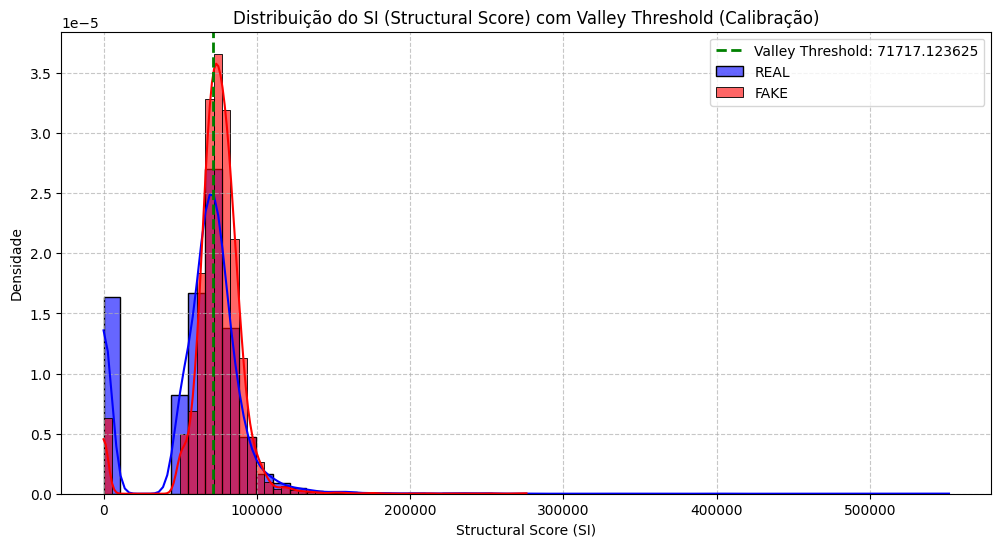

In [ ]:
plt.figure(figsize=(12, 6))

# Hist REAL
sns.histplot(S_R, color='blue', label='REAL', kde=True, stat='density',
             alpha=0.6, bins=50)

# Hist FAKE
sns.histplot(S_F, color='red', label='FAKE', kde=True, stat='density',
             alpha=0.6, bins=50)

# Threshold do Algorithm 1
plt.axvline(si_threshold, color='green', linestyle='--', linewidth=2,
            label=f"Valley Threshold: {si_threshold:.6f}")

plt.title("Distribuição do SI (Structural Score) com Valley Threshold (Calibração)")
plt.xlabel("Structural Score (SI)")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## Aplicar o limiar nos scores das imagens classificadas incorretamente


Aplicamos o limiar determinado nos scores S das imagens classificadas incorretamente para verificar se o módulo EBP consegue reclassificá-las corretamente.


In [ ]:
torch.backends.cudnn.benchmark = True

# DataLoader mais rápido
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    num_workers=4,
    pin_memory=True,
    shuffle=False
)

model.to(device)
model.eval()

vit_predictions = []
vit_true_labels = []

print(f"Gerando predições do ViT para {len(test_dataset)} imagens (com AMP fp16)...")

# ---- INFERÊNCIA  ----
with torch.no_grad():
    for batch_images, batch_labels in tqdm(test_loader, desc="Processando"):

        # Envia para GPU
        batch_images = batch_images.to(device, non_blocking=True)

        # Mixed precision: usa fp16
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            outputs = model(batch_images)

        preds = torch.argmax(outputs.logits, dim=1).cpu().tolist()
        labs = batch_labels.tolist()

        vit_predictions.extend([id2label[p] for p in preds])
        vit_true_labels.extend([id2label[l] for l in labs])

print("Predições do ViT concluídas com sucesso.")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Gerando predições do ViT para 20000 imagens (com AMP fp16)...


Processando: 100%|██████████| 157/157 [01:11<00:00,  2.18it/s]

Predições do ViT concluídas com sucesso.


In [ ]:
print("Recalculando Structural Score (SI) e aplicando o limiar EBP para reclassificar imagens incorretas do ViT...")

eb_reclassified_correctly_count = 0
for i, item in enumerate(misclassified_images):

    if 'Nedges' not in item or 'var_D' not in item:
        D = calculate_edge_difference_map(item["E_orig"], item["E_blur"])
        item["Nedges"], item["var_D"] = calculate_n_and_var_d(item["E_orig"], D)

    item["SI"] = calculate_structural_score_SI(item["Nedges"], item["var_D"], epsilon)

    # O EBP classifica como 'REAL' se SI < si_threshold, 'FAKE' se SI >= si_threshold
    ebp_prediction = 'REAL' if item['SI'] < si_threshold else 'FAKE'
    item['ebp_prediction'] = ebp_prediction

    # Verificar se a reclassificação do EBP corrigiu o erro do ViT
    if ebp_prediction == item['true_label']:
        ebp_reclassified_correctly_count += 1

    if (i + 1) % 50 == 0:
        print(f"  Processadas {i + 1}/{len(misclassified_images)} imagens. Corrigidas até agora: {ebp_reclassified_correctly_count}")

print(f"\nReclassificação EBP concluída. Total de misclassificações corrigidas: {ebp_reclassified_correctly_count}")


Recalculando Structural Score (SI) e aplicando o limiar EBP para reclassificar imagens incorretas do ViT...
  Processadas 50/221 imagens. Corrigidas até agora: 23
  Processadas 100/221 imagens. Corrigidas até agora: 45
  Processadas 150/221 imagens. Corrigidas até agora: 70
  Processadas 200/221 imagens. Corrigidas até agora: 98

Reclassificação EBP concluída. Total de misclassificações corrigidas: 107


In [ ]:
# 1. Calcular as métricas do ViT (modelo base) no conjunto de teste completo
vit_accuracy = accuracy_score(vit_true_labels, vit_predictions)
vit_precision = precision_score(vit_true_labels, vit_predictions, pos_label='REAL')
vit_recall = recall_score(vit_true_labels, vit_predictions, pos_label='REAL')
vit_f1 = f1_score(vit_true_labels, vit_predictions, pos_label='REAL')

print("\n--- Performance do Modelo ViT (Base) ---")
print(f"Acurácia: {vit_accuracy:.4f}")
print(f"Precisão (REAL): {vit_precision:.4f}")
print(f"Recall (REAL): {vit_recall:.4f}")
print(f"F1-Score (REAL): {vit_f1:.4f}")

# 2. Calcular a performance do sistema híbrido


hybrid_predictions = list(vit_predictions) # Começa com todas as predições do ViT


# Re-identificar as imagens misclassificadas com seus índices do test_dataset
vit_misclassified_indices = []
for i in range(len(vit_true_labels)):
    if vit_true_labels[i] != vit_predictions[i]:
        vit_misclassified_indices.append(i)

# Assumindo que a ordem de 'misclassified_images' corresponde à ordem em que ViT as misclassificou

if len(misclassified_images) == len(vit_misclassified_indices):
    for i, mis_item in enumerate(misclassified_images):
        original_test_idx = vit_misclassified_indices[i]
        # Se a predição do EBP for diferente da predição original do ViT para esta imagem
        # E se a predição do EBP for a correta (true_label)
        if mis_item['ebp_prediction'] == mis_item['true_label']:
            hybrid_predictions[original_test_idx] = mis_item['ebp_prediction']


# Calcular métricas do sistema híbrido
hybrid_accuracy = accuracy_score(vit_true_labels, hybrid_predictions)
hybrid_precision = precision_score(vit_true_labels, hybrid_predictions, pos_label='REAL')
hybrid_recall = recall_score(vit_true_labels, hybrid_predictions, pos_label='REAL')
hybrid_f1 = f1_score(vit_true_labels, hybrid_predictions, pos_label='REAL')

print("\n--- Performance do Sistema Híbrido (ViT + EBP) ---")
print(f"Acurácia: {hybrid_accuracy:.4f}")
print(f"Precisão (REAL): {hybrid_precision:.4f}")
print(f"Recall (REAL): {hybrid_recall:.4f}")
print(f"F1-Score (REAL): {hybrid_f1:.4f}")

print(f"\nNúmero de imagens originalmente misclassificadas pelo ViT: {len(misclassified_images)}")
print(f"Número de misclassificações corrigidas pelo EBP: {ebp_reclassified_correctly_count}")
print(f"Melhoria na Acurácia devido ao EBP: {(hybrid_accuracy - vit_accuracy):.4f}")

print("\n--- Análise Final do Sistema Híbrido ---")
print(f"O modelo ViT sozinho alcançou uma acurácia de {vit_accuracy:.4f} no conjunto de teste.")
print(f"Identificamos {len(misclassified_images)} imagens que foram incorretamente classificadas pelo ViT.")
print(f"Dessas, o módulo EBP conseguiu corrigir {ebp_reclassified_correctly_count} misclassificações, o que representa uma taxa de correção de {(ebp_reclassified_correctly_count / len(misclassified_images)):.2%} das falhas do ViT.")
print(f"Como resultado, a acurácia geral do sistema híbrido aumentou para {hybrid_accuracy:.4f}, uma melhoria de {(hybrid_accuracy - vit_accuracy):.2%} em relação ao ViT isolado.")



--- Performance do Modelo ViT (Base) ---
Acurácia: 0.9889
Precisão (REAL): 0.9903
Recall (REAL): 0.9876
F1-Score (REAL): 0.9889

--- Performance do Sistema Híbrido (ViT + EBP) ---
Acurácia: 0.9943
Precisão (REAL): 0.9947
Recall (REAL): 0.9939
F1-Score (REAL): 0.9943

Número de imagens originalmente misclassificadas pelo ViT: 221
Número de misclassificações corrigidas pelo EBP: 107
Melhoria na Acurácia devido ao EBP: 0.0053

--- Análise Final do Sistema Híbrido ---
O sistema híbrido combina a capacidade de reconhecimento visual profundo do ViT com a análise de artefatos de alta frequência do EBP.
O modelo ViT sozinho alcançou uma acurácia de 0.9889 no conjunto de teste.
Identificamos 221 imagens que foram incorretamente classificadas pelo ViT.
Dessas, o módulo EBP conseguiu corrigir 107 misclassificações, o que representa uma taxa de correção de 48.42% das falhas do ViT.
Como resultado, a acurácia geral do sistema híbrido aumentou para 0.9943, uma melhoria de 0.53% em relação ao ViT is

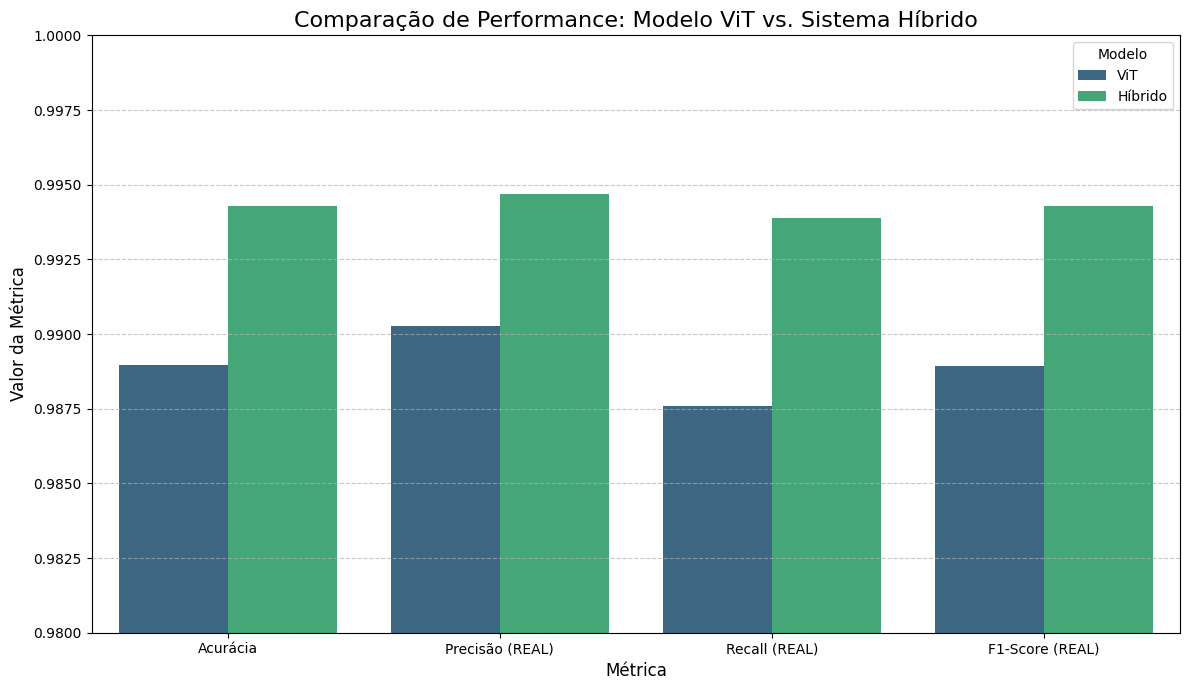

Visualização das métricas de performance gerada com sucesso.


In [ ]:
# Dados do ViT (base)
vit_scores = [
    vit_accuracy,
    vit_precision,
    vit_recall,
    vit_f1
]

# Dados do sistema híbrido
hybrid_scores = [
    hybrid_accuracy,
    hybrid_precision,
    hybrid_recall,
    hybrid_f1
]

metrics = ['Acurácia', 'Precisão (REAL)', 'Recall (REAL)', 'F1-Score (REAL)']

data = {
    'Métrica': metrics + metrics,
    'Valor': vit_scores + hybrid_scores,
    'Modelo': ['ViT'] * len(metrics) + ['Híbrido'] * len(metrics)
}

df_metrics = pd.DataFrame(data)

plt.figure(figsize=(12, 7))
sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=df_metrics, palette='viridis')
plt.ylim(0.98, 1.0) # Ajuste o limite Y para focar nas diferenças
plt.title('Comparação de Performance: Modelo ViT vs. Sistema Híbrido', fontsize=16)
plt.ylabel('Valor da Métrica', fontsize=12)
plt.xlabel('Métrica', fontsize=12)
plt.legend(title='Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Visualização das métricas de performance gerada com sucesso.")



--- Lift Chart: Melhoria Percentual --- 
           Métrica  Melhoria Absoluta  Melhoria Percentual (%)
0         Acurácia             0.0053                   0.5410
1  Precisão (REAL)             0.0044                   0.4465
2    Recall (REAL)             0.0063                   0.6379
3  F1-Score (REAL)             0.0054                   0.5423


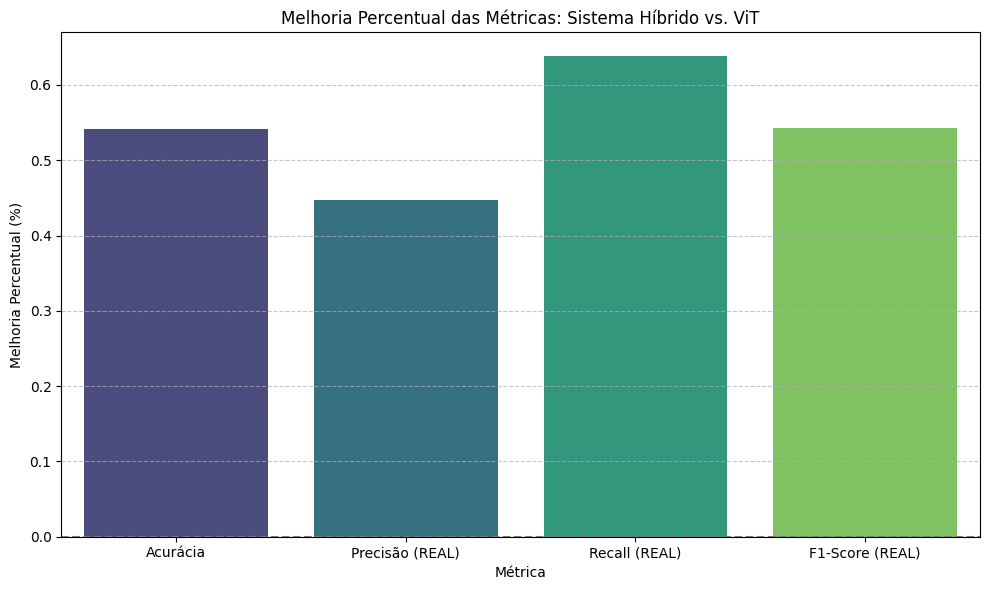

Gráfico de Melhoria Percentual (Lift Chart) gerado.


In [ ]:
# (Melhoria Percentual)

metrics_data = {
    'Métrica': ['Acurácia', 'Precisão (REAL)', 'Recall (REAL)', 'F1-Score (REAL)'],
    'ViT': [vit_accuracy, vit_precision, vit_recall, vit_f1],
    'Híbrido': [hybrid_accuracy, hybrid_precision, hybrid_recall, hybrid_f1]
}
df_metrics = pd.DataFrame(metrics_data)

df_metrics['Melhoria Absoluta'] = df_metrics['Híbrido'] - df_metrics['ViT']
# Avoid division by zero if original metric is 0, though not expected for these metrics
df_metrics['Melhoria Percentual (%)'] = (df_metrics['Melhoria Absoluta'] / df_metrics['ViT']) * 100

print("\n--- Lift Chart: Melhoria Percentual --- ")
print(df_metrics[['Métrica', 'Melhoria Absoluta', 'Melhoria Percentual (%)']].round(4))

plt.figure(figsize=(10, 6))
sns.barplot(x='Métrica', y='Melhoria Percentual (%)', data=df_metrics, palette='viridis', hue='Métrica', legend=False) # Fixed FutureWarning
plt.axhline(0, color='gray', linestyle='--')
plt.title('Melhoria Percentual das Métricas: Sistema Híbrido vs. ViT')
plt.ylabel('Melhoria Percentual (%)')
plt.xlabel('Métrica')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Gráfico de Melhoria Percentual (Lift Chart) gerado.")

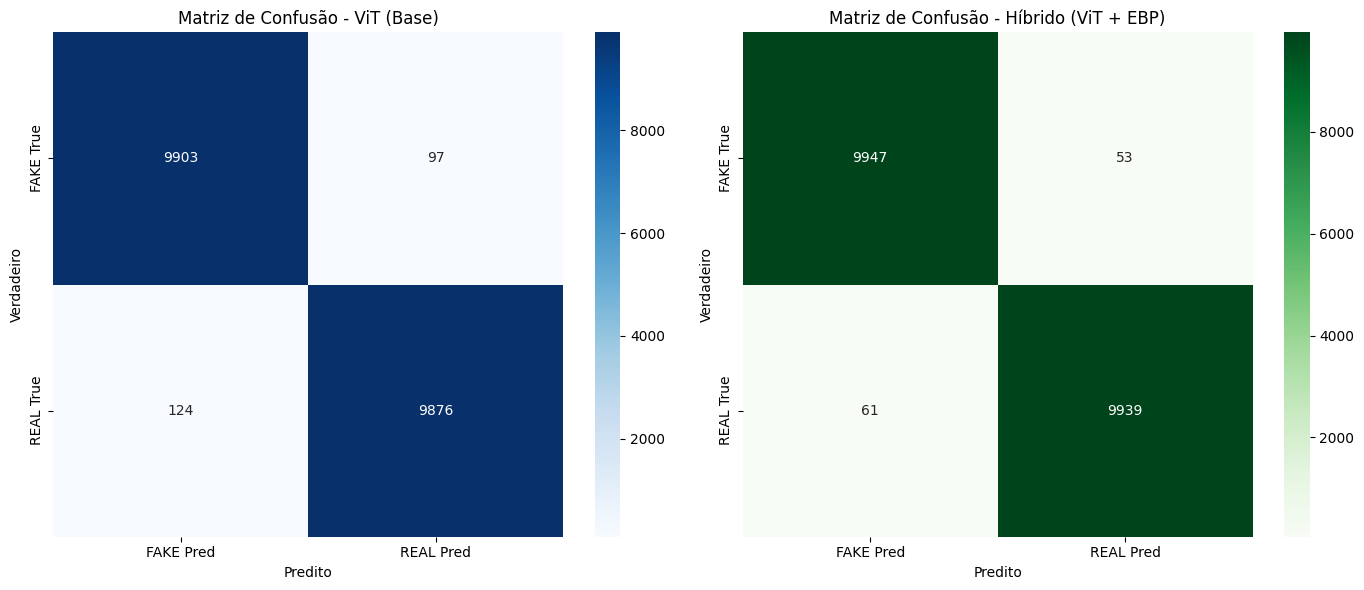

Matrizes de Confusão para ViT e Híbrido geradas com sucesso.


In [ ]:
#  matrix  ViT FinneTunned
cm_vit = confusion_matrix(vit_true_labels, vit_predictions, labels=['FAKE', 'REAL'])

#  matrix Hybrid
cm_hybrid = confusion_matrix(vit_true_labels, hybrid_predictions, labels=['FAKE', 'REAL'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot ViT Confusion Matrix
sns.heatmap(cm_vit, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['FAKE Pred', 'REAL Pred'], yticklabels=['FAKE True', 'REAL True'])
axes[0].set_title('Matriz de Confusão - ViT ImgNet21k (FinneTunned CIFAKER)')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Verdadeiro')

sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['FAKE Pred', 'REAL Pred'], yticklabels=['FAKE True', 'REAL True'])
axes[1].set_title('Matriz de Confusão - Híbrido (ViT + EBP)')
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('Verdadeiro')

plt.tight_layout()
plt.show()

print("Matrizes de Confusão para ViT e Híbrido geradas com sucesso.")

# Vizualiazando Processo do EBP


In [ ]:
corrected_image_for_visualization = None

for item in misclassified_images:
    if item['ebp_prediction'] == item['true_label']:
        corrected_image_for_visualization = item
        break

if corrected_image_for_visualization:
    print("\n--- Imagem Corrigida Pelo EBP Encontrada para Visualização ---")
    print(f"Rótulo Verdadeiro: {corrected_image_for_visualization['true_label']}")
    print(f"Predição ViT: {corrected_image_for_visualization['predicted_label']}")
    print(f"Predição EBP: {corrected_image_for_visualization['ebp_prediction']}")
    print("Esta imagem será usada para visualizações futuras.")
else:
    print("\nNenhuma imagem misclassificada pelo ViT foi corrigida pelo EBP.")


--- Imagem Corrigida Pelo EBP Encontrada para Visualização ---
Rótulo Verdadeiro: FAKE
Predição ViT: REAL
Predição EBP: FAKE
Esta imagem será usada para visualizações futuras.


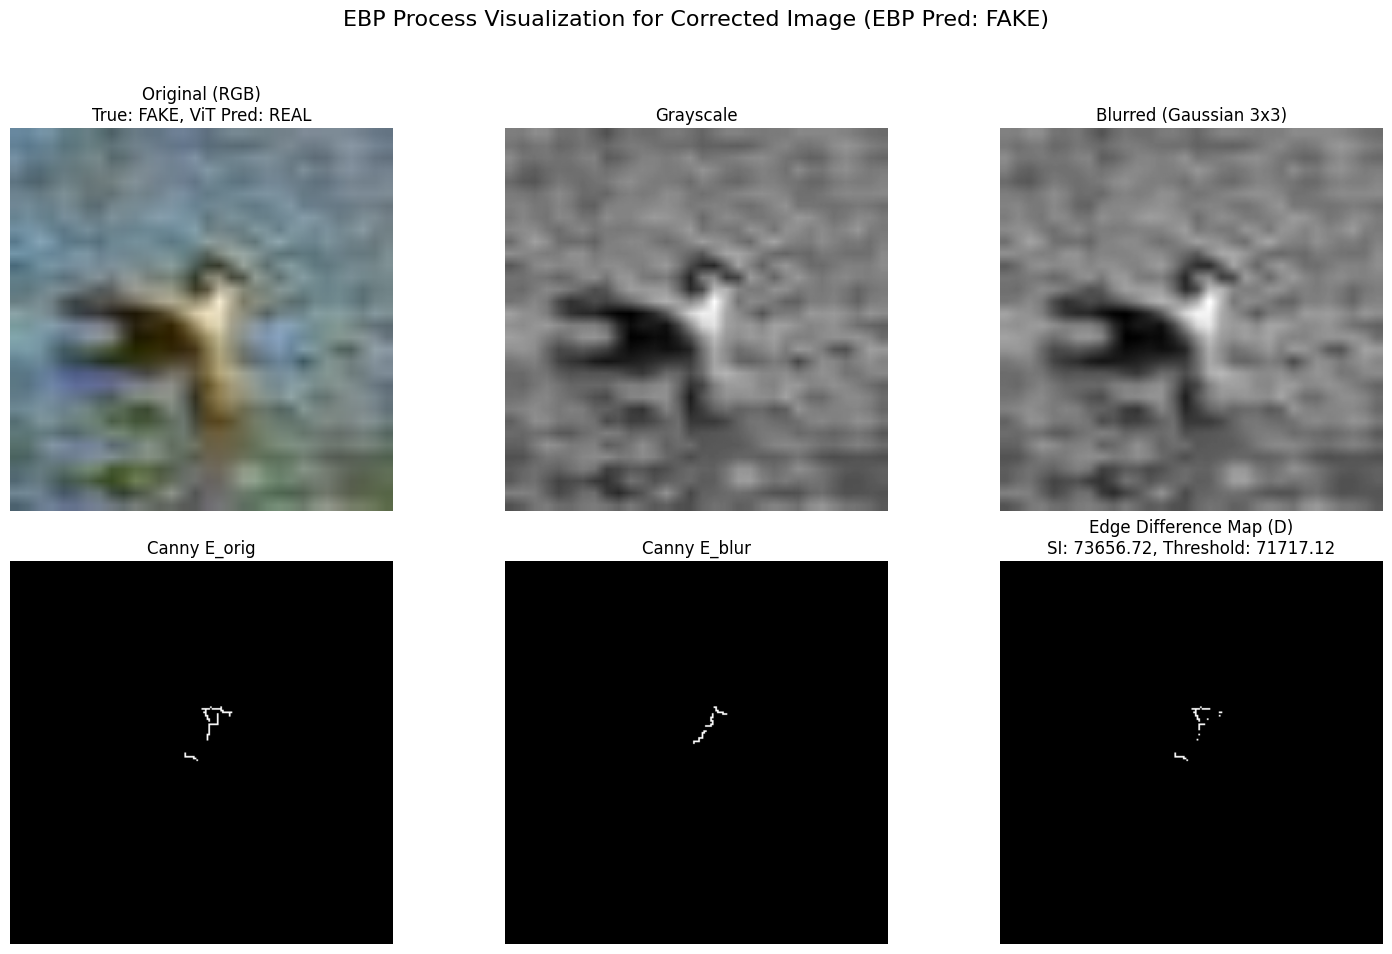

In [ ]:
if corrected_image_for_visualization:
    item = corrected_image_for_visualization

    denorm_rgb = denormalize_image_tensor(item['image_tensor'], mean, std)
    gray_img, blurred_img = preprocess_for_ebp(denorm_rgb)
    E_orig = apply_canny(gray_img)
    E_blur = apply_canny(blurred_img)
    D = calculate_edge_difference_map(E_orig, E_blur)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # 1. Denormalized Original Image (RGB)
    axes[0].imshow(denorm_rgb)
    axes[0].set_title(f"Original (RGB)\nTrue: {item['true_label']}, ViT Pred: {item['predicted_label']}")
    axes[0].axis('off')

    # 2. Grayscale
    axes[1].imshow(gray_img, cmap='gray')
    axes[1].set_title("Grayscale")
    axes[1].axis('off')

    # 3. Blurred Grayscale
    axes[2].imshow(blurred_img, cmap='gray')
    axes[2].set_title("Blurred (Gaussian 3x3)")
    axes[2].axis('off')

    # 4. Canny Edge Map (E_orig)
    axes[3].imshow(E_orig, cmap='gray')
    axes[3].set_title("Canny E_orig")
    axes[3].axis('off')

    # 5. Canny Edge Map (E_blur)
    axes[4].imshow(E_blur, cmap='gray')
    axes[4].set_title("Canny E_blur")
    axes[4].axis('off')

    # 6. Edge Difference Map (D)
    axes[5].imshow(D, cmap='gray')
    axes[5].set_title(f"Edge Difference Map (D)\nSI: {item['SI']:.2f}, Threshold: {si_threshold:.2f}")
    axes[5].axis('off')

    plt.suptitle(f"EBP Process Visualization for Corrected Image (EBP Pred: {item['ebp_prediction']})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("Não foi possível visualizar o processo EBP, pois nenhuma imagem corrigida foi encontrada.")

In [ ]:
corrected_real_image_for_visualization = None

for item in misclassified_images:
    if item['true_label'] == 'REAL' and \
       item['predicted_label'] == 'FAKE' and \
       item['ebp_prediction'] == 'REAL':
        corrected_real_image_for_visualization = item
        break

if corrected_real_image_for_visualization:
    print("\n--- Imagem REAL Corrigida Pelo EBP Encontrada para Visualização ---")
    print(f"Rótulo Verdadeiro: {corrected_real_image_for_visualization['true_label']}")
    print(f"Predição ViT: {corrected_real_image_for_visualization['predicted_label']}")
    print(f"Predição EBP: {corrected_real_image_for_visualization['ebp_prediction']}")
    print("Esta imagem será usada para visualizações futuras.")
else:
    print("\nNenhuma imagem REAL misclassificada pelo ViT e corrigida pelo EBP foi encontrada.")


--- Imagem REAL Corrigida Pelo EBP Encontrada para Visualização ---
Rótulo Verdadeiro: REAL
Predição ViT: FAKE
Predição EBP: REAL
Esta imagem será usada para visualizações futuras.


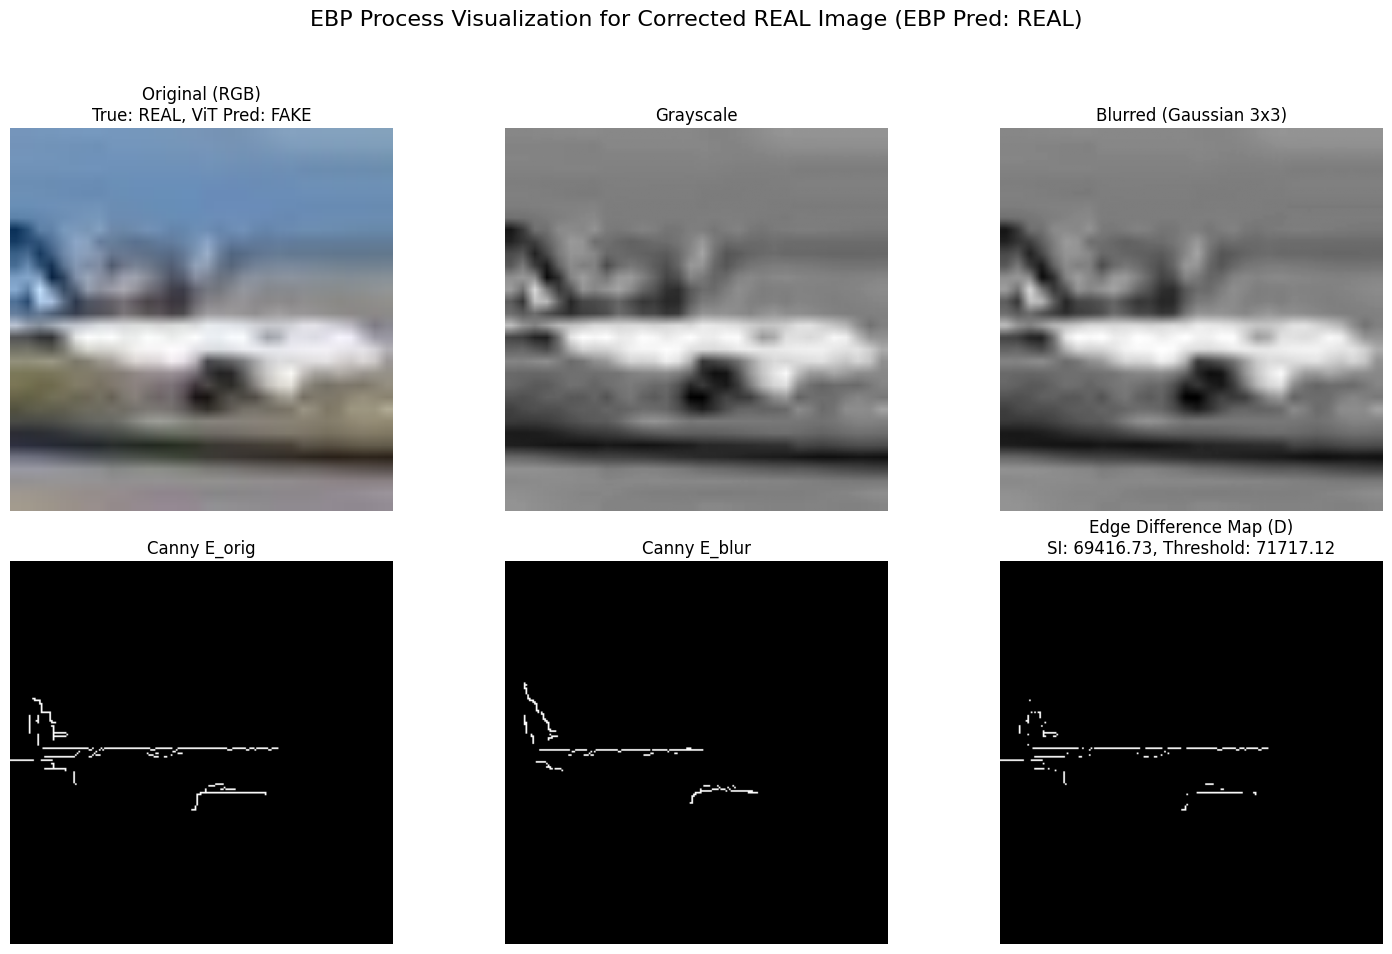

In [ ]:
if corrected_real_image_for_visualization:
    item = corrected_real_image_for_visualization


    denorm_rgb = denormalize_image_tensor(item['image_tensor'], mean, std)
    gray_img, blurred_img = preprocess_for_ebp(denorm_rgb)
    E_orig = apply_canny(gray_img)
    E_blur = apply_canny(blurred_img)
    D = calculate_edge_difference_map(E_orig, E_blur)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()


    axes[0].imshow(denorm_rgb)
    axes[0].set_title(f"Original (RGB)\nTrue: {item['true_label']}, ViT Pred: {item['predicted_label']}")
    axes[0].axis('off')


    axes[1].imshow(gray_img, cmap='gray')
    axes[1].set_title("Grayscale")
    axes[1].axis('off')


    axes[2].imshow(blurred_img, cmap='gray')
    axes[2].set_title("Blurred (Gaussian 3x3)")
    axes[2].axis('off')


    axes[3].imshow(E_orig, cmap='gray')
    axes[3].set_title("Canny E_orig")
    axes[3].axis('off')


    axes[4].imshow(E_blur, cmap='gray')
    axes[4].set_title("Canny E_blur")
    axes[4].axis('off')


    axes[5].imshow(D, cmap='gray')
    axes[5].set_title(f"Edge Difference Map (D)\nSI: {item['SI']:.2f}, Threshold: {si_threshold:.2f}")
    axes[5].axis('off')

    plt.suptitle(f"EBP Process Visualization for Corrected REAL Image (EBP Pred: {item['ebp_prediction']})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("Não foi possível visualizar o processo EBP, pois nenhuma imagem REAL corrigida foi encontrada.")

In [ ]:
different_corrected_fake_image_for_visualization = None

previous_image_tensor = None
if corrected_image_for_visualization and isinstance(corrected_image_for_visualization, dict):
    previous_image_tensor = corrected_image_for_visualization.get('image_tensor')

for item in misclassified_images:
    conditions_met = (
        item['true_label'] == 'FAKE' and
        item['predicted_label'] == 'REAL' and
        item['ebp_prediction'] == 'FAKE'
    )

    if conditions_met:
        if previous_image_tensor is None or not torch.equal(item['image_tensor'], previous_image_tensor):
            different_corrected_fake_image_for_visualization = item
            break

if different_corrected_fake_image_for_visualization:
    print("\n--- Different FAKE Image Corrigida Pelo EBP Encontrada para Visualização ---")
    print(f"Rótulo Verdadeiro: {different_corrected_fake_image_for_visualization['true_label']}")
    print(f"Predição ViT: {different_corrected_fake_image_for_visualization['predicted_label']}")
    print(f"Predição EBP: {different_corrected_fake_image_for_visualization['ebp_prediction']}")
    print("Esta imagem será usada para visualizações futuras.")
else:
    print("\nNenhuma imagem FAKE diferente que foi misclassificada pelo ViT e corrigida pelo EBP foi encontrada.")


--- Different FAKE Image Corrigida Pelo EBP Encontrada para Visualização ---
Rótulo Verdadeiro: FAKE
Predição ViT: REAL
Predição EBP: FAKE
Esta imagem será usada para visualizações futuras.


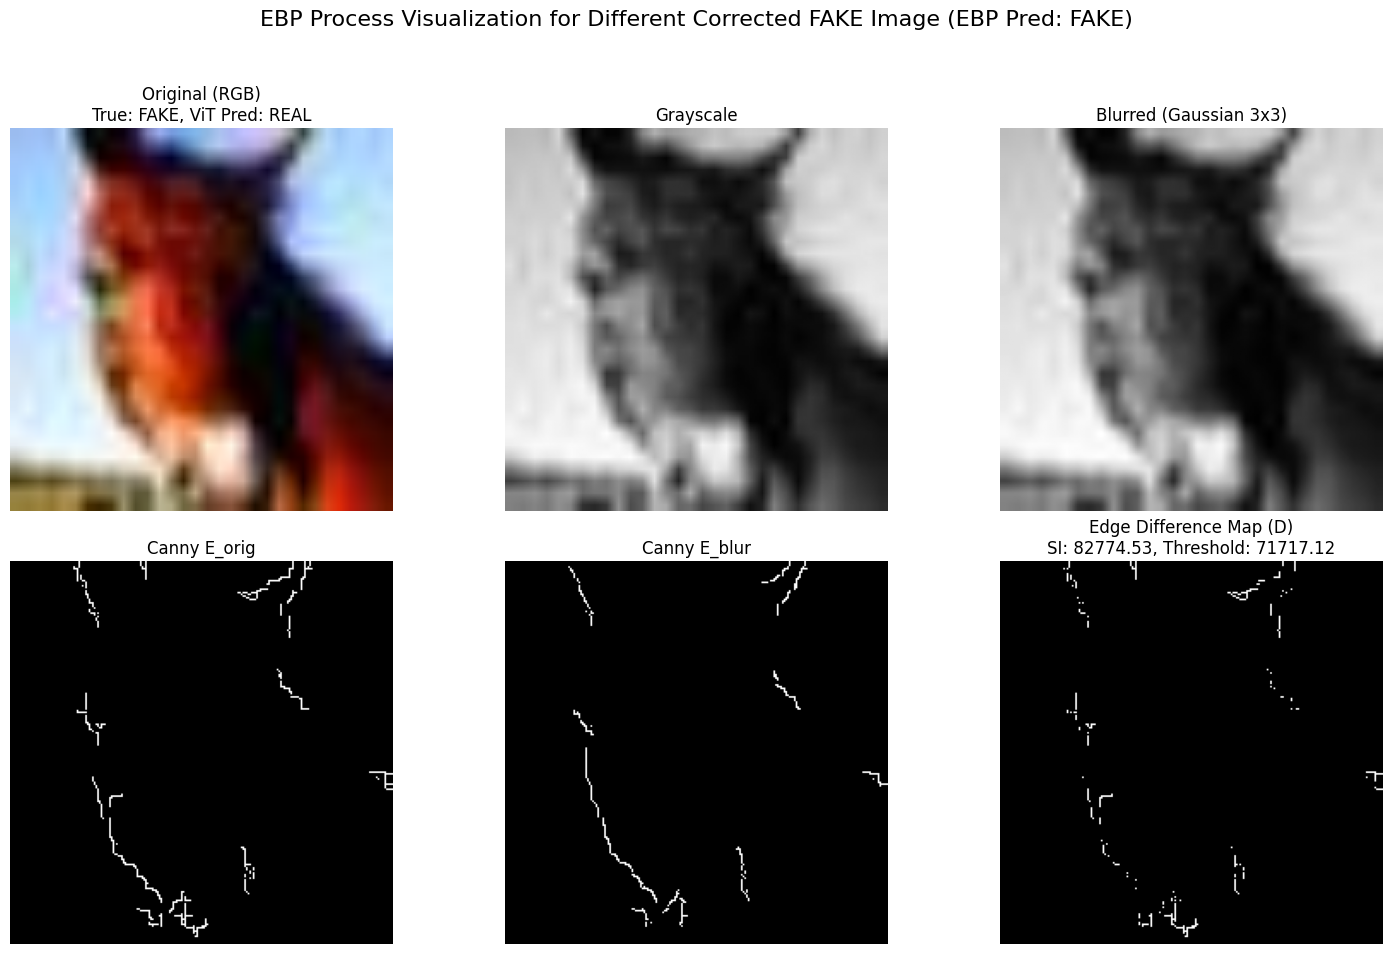

In [ ]:
if different_corrected_fake_image_for_visualization:
    item = different_corrected_fake_image_for_visualization


    denorm_rgb = denormalize_image_tensor(item['image_tensor'], mean, std)
    gray_img, blurred_img = preprocess_for_ebp(denorm_rgb)
    E_orig = apply_canny(gray_img)
    E_blur = apply_canny(blurred_img)
    D = calculate_edge_difference_map(E_orig, E_blur)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()


    axes[0].imshow(denorm_rgb)
    axes[0].set_title(f"Original (RGB)\nTrue: {item['true_label']}, ViT Pred: {item['predicted_label']}")
    axes[0].axis('off')


    axes[1].imshow(gray_img, cmap='gray')
    axes[1].set_title("Grayscale")
    axes[1].axis('off')


    axes[2].imshow(blurred_img, cmap='gray')
    axes[2].set_title("Blurred (Gaussian 3x3)")
    axes[2].axis('off')


    axes[3].imshow(E_orig, cmap='gray')
    axes[3].set_title("Canny E_orig")
    axes[3].axis('off')


    axes[4].imshow(E_blur, cmap='gray')
    axes[4].set_title("Canny E_blur")
    axes[4].axis('off')


    axes[5].imshow(D, cmap='gray')
    axes[5].set_title(f"Edge Difference Map (D)\nSI: {item['SI']:.2f}, Threshold: {si_threshold:.2f}")
    axes[5].axis('off')

    plt.suptitle(f"EBP Process Visualization for Different Corrected FAKE Image (EBP Pred: {item['ebp_prediction']})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("Não foi possível visualizar o processo EBP, pois nenhuma imagem FAKE corrigida diferente foi encontrada.")

# **Coletando metricas do Vit imgnet21k only, também coletando EBP only e Vit img21k(base) + ebp, sem finnetunning**


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


BATCH_SIZE = 128

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

vit_predictions_base = []
vit_true_labels_base = []

print(f"🔍 Gerando predições para {len(test_dataset)} imagens de teste...")


with torch.inference_mode():
    for batch_images, batch_labels in tqdm.tqdm(test_loader, desc="ViT Inference"):

        batch_images = batch_images.to(device, non_blocking=True)

        outputs = model(batch_images)
        logits = outputs.logits


        pred_idx = torch.argmax(logits, dim=1)

        # Mapeia id para nome REAL/FAKE de forma rápida
        vit_predictions_base.extend([id2label[i] for i in pred_idx.cpu().tolist()])
        vit_true_labels_base.extend([id2label[i] for i in batch_labels.tolist()])

print("✅ Predições concluídas.")

# MÉTRICAS


POS_CLASS = "REAL"

accuracy_base  = accuracy_score(vit_true_labels_base, vit_predictions_base)
precision_base = precision_score(vit_true_labels_base, vit_predictions_base, pos_label=POS_CLASS)
recall_base    = recall_score(vit_true_labels_base, vit_predictions_base, pos_label=POS_CLASS)
f1_base        = f1_score(vit_true_labels_base, vit_predictions_base, pos_label=POS_CLASS)


# RESULTADOS

print("\n --- Desempenho do ViT (Base) ---")
print(f"✔ Acurácia:  {accuracy_base:.4f}")
print(f"✔ Precisão ({POS_CLASS}): {precision_base:.4f}")
print(f"✔ Recall ({POS_CLASS}):    {recall_base:.4f}")
print(f"✔ F1-Score ({POS_CLASS}):  {f1_base:.4f}")


🔍 Gerando predições para 20000 imagens de teste...


ViT Inference: 100%|██████████| 157/157 [03:16<00:00,  1.25s/it]


✅ Predições concluídas.

📊 --- Desempenho do ViT (Base) ---
✔ Acurácia:  0.4923
✔ Precisão (REAL): 0.4936
✔ Recall (REAL):    0.5946
✔ F1-Score (REAL):  0.5394


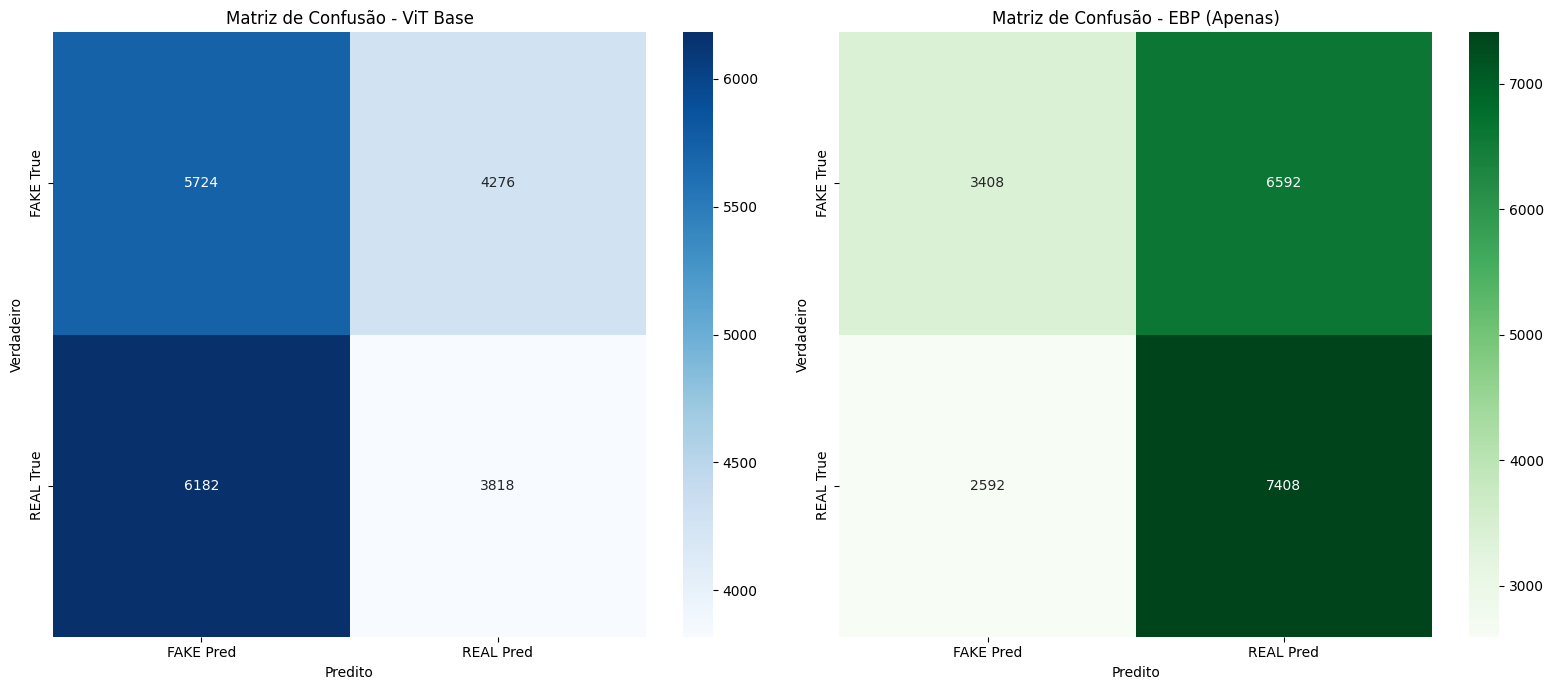

Matrizes de Confusão para ViT Base e EBP (Apenas) geradas com sucesso.


In [ ]:
#  ViT Base
cm_vit_base = confusion_matrix(vit_true_labels_base, vit_predictions_base, labels=['FAKE', 'REAL'])

# EBP Only
cm_ebp_only = confusion_matrix(ebp_true, ebp_predictions, labels=['FAKE', 'REAL'])

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot ViT Base
sns.heatmap(cm_vit_base, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['FAKE Pred', 'REAL Pred'], yticklabels=['FAKE True', 'REAL True'])
axes[0].set_title('Matriz de Confusão - ViT Base')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Verdadeiro')

# Plot EBP Only
sns.heatmap(cm_ebp_only, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['FAKE Pred', 'REAL Pred'], yticklabels=['FAKE True', 'REAL True'])
axes[1].set_title('Matriz de Confusão - EBP (Apenas)')
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('Verdadeiro')

plt.tight_layout()
plt.show()

print("Matrizes de Confusão para ViT Base e EBP (Apenas) geradas com sucesso.")

## ViT Base Misclassified Images


In [23]:
vit_base_misclassified_images = []

print(f"Identifying misclassified images from ViT Base predictions ({len(vit_true_labels_base)} total images)...")

for i in range(len(vit_true_labels_base)):
    true_label_name = vit_true_labels_base[i]
    predicted_label_name = vit_predictions_base[i]

    if true_label_name != predicted_label_name:
        # Retrieve the image tensor and true label index from test_dataset
        image_tensor, true_label_idx = test_dataset[i]

        vit_base_misclassified_images.append({
            'image_tensor': image_tensor.cpu(),  # Move to CPU to save GPU memory
            'true_label': true_label_name,
            'predicted_label': predicted_label_name
        })

    if (i + 1) % 5000 == 0:
        print(f"  Processed {i + 1}/{len(vit_true_labels_base)} images...")

print(f"Identification complete. Total misclassified images by ViT Base: {len(vit_base_misclassified_images)}")

Identifying misclassified images from ViT Base predictions (20000 total images)...
  Processed 5000/20000 images...
  Processed 10000/20000 images...
  Processed 15000/20000 images...
  Processed 20000/20000 images...
Identification complete. Total misclassified images by ViT Base: 10155


In [26]:
def apply_canny(img):
    return cv2.Canny(img, threshold1=50, threshold2=150)

mean = processor.image_mean
std = processor.image_std

total_mis_base = len(vit_base_misclassified_images)
print(f"Processando {total_mis_base} imagens classificadas incorretamente pelo ViT Base para EBP...")

# Definir tamanho dos passos de progresso (20 updates)
progress_step = max(1, total_mis_base // 20)

for i, item in enumerate(vit_base_misclassified_images):

    image_tensor = item["image_tensor"]

    # 1. Desnormalização
    denorm = denormalize_image_tensor(image_tensor, mean, std)

    # 2. Gerar grayscale + blur
    gray_img, blurred_img = preprocess_for_ebp(denorm)

    # 3. Aplicar Canny edge detection
    E_orig = apply_canny(gray_img)
    E_blur = apply_canny(blurred_img)

    # 4. Atualiza estrutura do item
    item["original_grayscale"] = gray_img
    item["blurred"] = blurred_img
    item["E_orig"] = E_orig
    item["E_blur"] = E_blur

    # Progresso em 20 passos
    if (i + 1) % progress_step == 0:
        print(f"  Processadas: {i + 1}/{total_mis_base}")

print("\nProcessamento das imagens misclassificadas pelo ViT Base para EBP concluído.")
print(f"Total de imagens processadas: {len(vit_base_misclassified_images)}")

Processando 10155 imagens classificadas incorretamente pelo ViT Base para EBP...
  Processadas: 507/10155
  Processadas: 1014/10155
  Processadas: 1521/10155
  Processadas: 2028/10155
  Processadas: 2535/10155
  Processadas: 3042/10155
  Processadas: 3549/10155
  Processadas: 4056/10155
  Processadas: 4563/10155
  Processadas: 5070/10155
  Processadas: 5577/10155
  Processadas: 6084/10155
  Processadas: 6591/10155
  Processadas: 7098/10155
  Processadas: 7605/10155
  Processadas: 8112/10155
  Processadas: 8619/10155
  Processadas: 9126/10155
  Processadas: 9633/10155
  Processadas: 10140/10155

Processamento das imagens misclassificadas pelo ViT Base para EBP concluído.
Total de imagens processadas: 10155


In [27]:
print("Calculando Structural Score (SI) para imagens misclassificadas pelo ViT Base...")

for i, item in enumerate(vit_base_misclassified_images):

    # 1. Construir D (Edge Difference Map)
    D = calculate_edge_difference_map(item["E_orig"], item["E_blur"])

    # 2. Calcular Nedges e var(D) = estatísticas estruturais do paper
    Nedges, var_D = calculate_n_and_var_d(item["E_orig"], D)

    # 3. Calcular o Structural Score SI
    item["SI"] = calculate_structural_score_SI(Nedges, var_D, epsilon)

    # progresso
    if (i + 1) % 1000 == 0:
        print(f"  SI calculado para {i + 1}/{len(vit_base_misclassified_images)} imagens.")

print("Structural Score (SI) calculado para todas as imagens misclassificadas pelo ViT Base.")

Calculando Structural Score (SI) para imagens misclassificadas pelo ViT Base...
  SI calculado para 1000/10155 imagens.
  SI calculado para 2000/10155 imagens.
  SI calculado para 3000/10155 imagens.
  SI calculado para 4000/10155 imagens.
  SI calculado para 5000/10155 imagens.
  SI calculado para 6000/10155 imagens.
  SI calculado para 7000/10155 imagens.
  SI calculado para 8000/10155 imagens.
  SI calculado para 9000/10155 imagens.
  SI calculado para 10000/10155 imagens.
Structural Score (SI) calculado para todas as imagens misclassificadas pelo ViT Base.


In [29]:
print("Aplicando o limiar EBP para reclassificar imagens incorretas do ViT Base...")

si_threshold = 71717.123625 # Explicitly define si_threshold based on previous calibration

eb_base_reclassified_correctly_count = 0
for i, item in enumerate(vit_base_misclassified_images):

    # O EBP classifica como 'REAL' se SI < si_threshold, 'FAKE' se SI >= si_threshold
    ebp_prediction = 'REAL' if item['SI'] < si_threshold else 'FAKE'
    item['ebp_prediction'] = ebp_prediction

    # Verificar se a reclassificação do EBP corrigiu o erro do ViT Base
    if ebp_prediction == item['true_label']:
        eb_base_reclassified_correctly_count += 1

    if (i + 1) % 1000 == 0:
        print(f"  Processadas {i + 1}/{len(vit_base_misclassified_images)} imagens. Corrigidas até agora: {eb_base_reclassified_correctly_count}")

print(f"\nReclassificação EBP para ViT Base concluída. Total de misclassificações corrigidas: {eb_base_reclassified_correctly_count}")


Aplicando o limiar EBP para reclassificar imagens incorretas do ViT Base...
  Processadas 1000/10155 imagens. Corrigidas até agora: 682
  Processadas 2000/10155 imagens. Corrigidas até agora: 1355
  Processadas 3000/10155 imagens. Corrigidas até agora: 2044
  Processadas 4000/10155 imagens. Corrigidas até agora: 2749
  Processadas 5000/10155 imagens. Corrigidas até agora: 3440
  Processadas 6000/10155 imagens. Corrigidas até agora: 4122
  Processadas 7000/10155 imagens. Corrigidas até agora: 4675
  Processadas 8000/10155 imagens. Corrigidas até agora: 5198
  Processadas 9000/10155 imagens. Corrigidas até agora: 5729
  Processadas 10000/10155 imagens. Corrigidas até agora: 6271

Reclassificação EBP para ViT Base concluída. Total de misclassificações corrigidas: 6355


In [30]:
hybrid_predictions_vit_base_ebp = list(vit_predictions_base)


vit_base_misclassified_indices = []
for i in range(len(vit_true_labels_base)):
    if vit_true_labels_base[i] != vit_predictions_base[i]:
        vit_base_misclassified_indices.append(i)

print(f"Total images misclassified by ViT Base: {len(vit_base_misclassified_indices)}")
print(f"Total misclassifications corrected by EBP: {eb_base_reclassified_correctly_count}")


for i, mis_item in enumerate(vit_base_misclassified_images):
    if mis_item['ebp_prediction'] == mis_item['true_label']:
        original_test_idx = vit_base_misclassified_indices[i]
        hybrid_predictions_vit_base_ebp[original_test_idx] = mis_item['ebp_prediction']

hybrid_base_accuracy = accuracy_score(vit_true_labels_base, hybrid_predictions_vit_base_ebp)
hybrid_base_precision = precision_score(vit_true_labels_base, hybrid_predictions_vit_base_ebp, pos_label='REAL')
hybrid_base_recall = recall_score(vit_true_labels_base, hybrid_predictions_vit_base_ebp, pos_label='REAL')
hybrid_base_f1 = f1_score(vit_true_labels_base, hybrid_predictions_vit_base_ebp, pos_label='REAL')

print("\n--- Performance do Sistema Híbrido (ViT Base + EBP) ---")
print(f"Acurácia: {hybrid_base_accuracy:.4f}")
print(f"Precisão (REAL): {hybrid_base_precision:.4f}")
print(f"Recall (REAL): {hybrid_base_recall:.4f}")
print(f"F1-Score (REAL): {hybrid_base_f1:.4f}")

print("\n--- Análise de Melhoria ---")
print(f"Acurácia do ViT Base original: {accuracy_base:.4f}")
print(f"Melhoria na Acurácia devido ao EBP: {(hybrid_base_accuracy - accuracy_base):.4f}")

Total images misclassified by ViT Base: 10155
Total misclassifications corrected by EBP: 6355

--- Performance do Sistema Híbrido (ViT Base + EBP) ---
Acurácia: 0.8100
Precisão (REAL): 0.8095
Recall (REAL): 0.8108
F1-Score (REAL): 0.8102

--- Análise de Melhoria ---
Acurácia do ViT Base original: 0.4923
Melhoria na Acurácia devido ao EBP: 0.3178


In [31]:
hybrid_base_scores = [
    hybrid_base_accuracy,
    hybrid_base_precision,
    hybrid_base_recall,
    hybrid_base_f1
]
print("Metrics for 'ViT Base + EBP' hybrid stored.")

Metrics for 'ViT Base + EBP' hybrid stored.


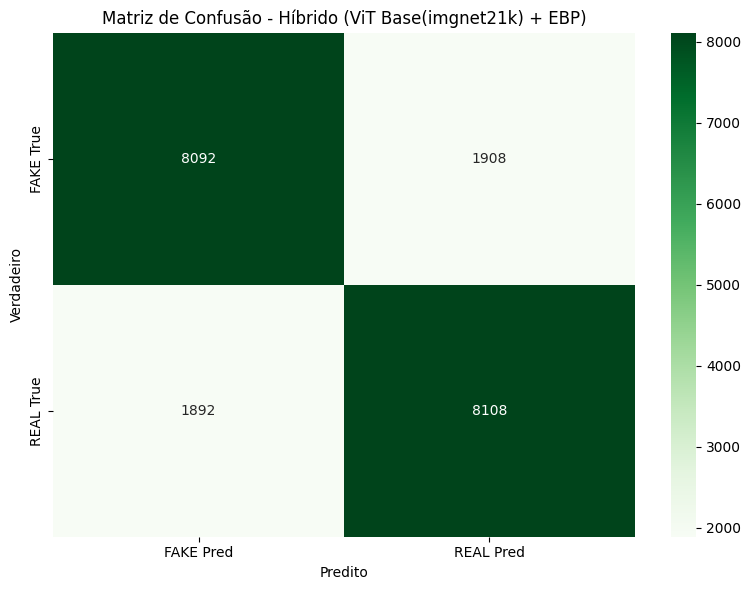

Confusion Matrix for 'ViT Base + EBP' hybrid generated.


In [36]:
cm_hybrid_base_ebp = confusion_matrix(vit_true_labels_base, hybrid_predictions_vit_base_ebp, labels=['FAKE', 'REAL'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid_base_ebp, annot=True, fmt='d', cmap='Greens',
            xticklabels=['FAKE Pred', 'REAL Pred'], yticklabels=['FAKE True', 'REAL True'])
plt.title('Matriz de Confusão - Híbrido (ViT Base(imgnet21k) + EBP)')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.tight_layout()
plt.show()

print("Confusion Matrix for 'ViT Base + EBP' hybrid generated.")

In [42]:
data = {
    "Modelo": [
        "ViT ImgNet21k (Finetuned) + EBP",
        "ViT ImgNet21k (Finetuned)",
        "ViT ImgNet21k (Base) + EBP",
        "EBP Only",
        "ViT ImgNet21k (Base) Only"
    ],

    "Accuracy":  [0.9943, 0.9889, 0.8100, 0.5408, 0.4771],
    "Precision": [0.9947, 0.9903, 0.8095, 0.5291, 0.4717],
    "Recall":    [0.9939, 0.9876, 0.8108, 0.7408, 0.3818],
    "F1-Score":  [0.9943, 0.9889, 0.8102, 0.6173, 0.4220],
}

df_metrics = pd.DataFrame(data)
df_metrics

,Modelo,Accuracy,Precision,Recall,F1-Score
0,ViT ImgNet21k (Finetuned) + EBP,0.9943,0.9947,0.9939,0.9943
1,ViT ImgNet21k (Finetuned),0.9889,0.9903,0.9876,0.9889
2,ViT ImgNet21k (Base) + EBP,0.8100,0.8095,0.8108,0.8102
3,EBP Only,0.5408,0.5291,0.7408,0.6173
4,ViT ImgNet21k (Base) Only,0.4771,0.4717,0.3818,0.4220


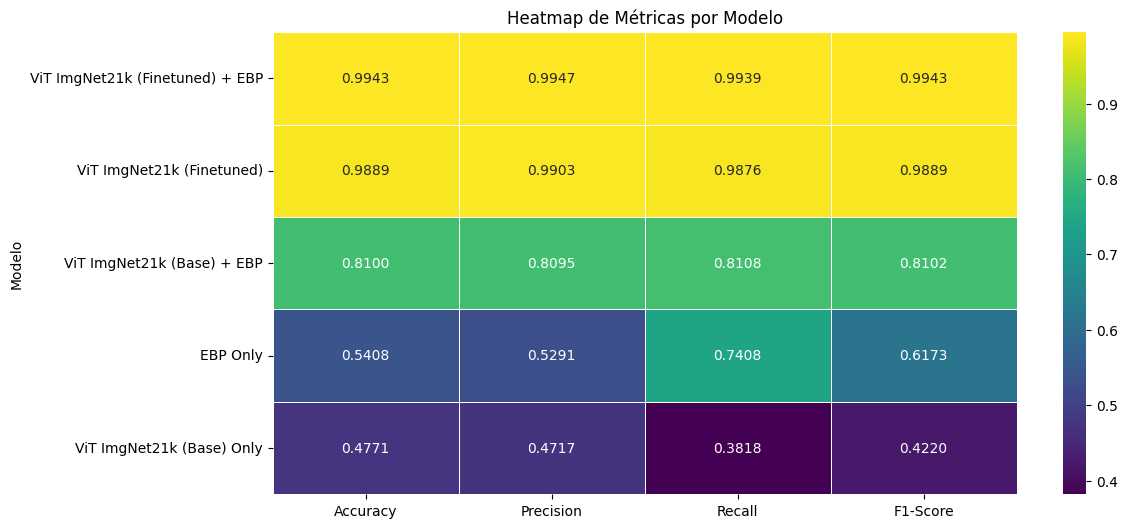

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(
    df_metrics.set_index("Modelo"),
    annot=True,
    cmap="viridis",
    linewidths=.5,
    fmt=".4f"
)

plt.title("Heatmap de Métricas por Modelo")
plt.show()


In [50]:
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

fig = go.Figure()

for i, row in df_metrics.iterrows():
    fig.add_trace(go.Bar(
        x=metrics,
        y=[row[m] for m in metrics],
        name=row["Modelo"]
    ))

fig.update_layout(
    title="-",
    xaxis_title="Métricas",
    yaxis_title="Score",
    barmode='group',  # barras agrupadas
    yaxis=dict(range=[0, 1.05]),
    legend=dict(orientation="h", yanchor="bottom", y=1.12, xanchor="center", x=0.5),
    template="plotly_white",
)

fig.show()


In [1]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification

# Define o diretório para salvar o modelo base
save_base_model_dir = "./vit-base-21k"
os.makedirs(save_base_model_dir, exist_ok=True)

print(f"Baixando e salvando o modelo ViT base (ImageNet-21k) para: {save_base_model_dir}")

# Baixa e carrega o modelo base
base_model = AutoModelForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')

# Baixa e carrega o preprocessor para o modelo base
base_processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Salva o modelo e o preprocessor
base_model.save_pretrained(save_base_model_dir)
base_processor.save_pretrained(save_base_model_dir)

print("Download e salvamento do modelo base e preprocessor concluídos.")
print(f"Arquivos salvos em '{save_base_model_dir}': {os.listdir(save_base_model_dir)}")

Baixando e salvando o modelo ViT base (ImageNet-21k) para: ./vit-base-21k


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Download e salvamento do modelo base e preprocessor concluídos.
Arquivos salvos em './vit-base-21k': ['model.safetensors', 'config.json', 'preprocessor_config.json']
